In [1]:
import torch
import pandas as pd
import numpy as np
import anndata
from scipy.spatial import distance
import scanpy as sc
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import functools
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm
import scanpy as sc
from collections import Counter
import matplotlib.cm as cm
from anndata import AnnData
import itertools as it
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.sparse import vstack
import time

In [2]:
class RNA_FNN_VAE(tf.keras.Model):
    """FNN variational autoencoder."""
    def __init__(self, latent_dim, n_feature, network_architecture, optimizer,
                 learning_rate, lambda_reconstruct, lambda_kl
                ):
        super(RNA_FNN_VAE, self).__init__()
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        if optimizer == 'Adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        if optimizer == 'Rmsprop':
            self.optimizer = tf.keras.optimizers.RMSprop(learning_rate)
        if optimizer == 'SGD':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate)
                
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.n_feature,)),
                tf.keras.layers.Dense( self.hidden_encode1, activation='relu'),
                tf.keras.layers.Dense( self.hidden_encode2, activation='relu'),
                tf.keras.layers.Dense( self.hidden_encode3, activation='relu'),
                # No activation
                tf.keras.layers.Dense(self.latent_dim + self.latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
                tf.keras.layers.Dense(self.hidden_decode1, activation='relu'),
                tf.keras.layers.Dense(self.hidden_decode2, activation='relu'),
                tf.keras.layers.Dense(self.hidden_decode3, activation='relu'),
                # No activation
                tf.keras.layers.Dense(self.n_feature),
            ]
        )
    
    ##Sample is called for prediction
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        reconstruct = self.decoder(z)
        return reconstruct

class ATAC_FNN_VAE(tf.keras.Model):
    """FNN variational autoencoder."""
    def __init__(self, latent_dim, n_feature, network_architecture, optimizer,
                 learning_rate, lambda_reconstruct, lambda_kl
                ):
        super(ATAC_FNN_VAE, self).__init__()
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        if optimizer == 'Adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        if optimizer == 'Rmsprop':
            self.optimizer = tf.keras.optimizers.RMSprop(learning_rate)
        if optimizer == 'SGD':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate)
                
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.n_feature,)),
                tf.keras.layers.Dense( self.hidden_encode1, activation='elu'),
                tf.keras.layers.Dense( self.hidden_encode2, activation='elu'),
                tf.keras.layers.Dense( self.hidden_encode3, activation='elu'),
                # No activation
                tf.keras.layers.Dense(self.latent_dim + self.latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
                tf.keras.layers.Dense(self.hidden_decode1, activation='elu'),
                tf.keras.layers.Dense(self.hidden_decode2, activation='elu'),
                tf.keras.layers.Dense(self.hidden_decode3, activation='elu'),
                # No activation
                tf.keras.layers.Dense(self.n_feature),
            ]
        )
    
    ##Sample is called for prediction
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        reconstruct = self.decoder(z)
        return reconstruct
    
    
def compute_loss(model, x):
    
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    
    reconstruction = model.decode(z)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction),1))
    
    kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    
    total_loss = model.lambda_reconstruct*reconstruction_loss + model.lambda_kl*kl_loss
    
    return total_loss

#@tf.function
def joint_train_step(model_rna, model_atac, rna_x, atac_x):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        rna_loss = compute_loss(model_rna, rna_x)
        atac_loss = compute_loss(model_atac, atac_x)
        total_loss = rna_loss + atac_loss
    
    joint_gradients = tape.gradient(total_loss, 
                                    model_rna.trainable_variables + model_atac.trainable_variables)
    
    model_rna.optimizer.apply_gradients(zip(joint_gradients, 
                                            model_rna.trainable_variables +model_atac.trainable_variables))
      
    return total_loss, rna_loss , atac_loss


def train_step(model, x):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return(loss)    


# In[ ]:


def joint_initialize_model(rna_x = None, atac_x = None, 
                           n_latent = 50, optimizer ='Adam',
                           learning_rate = 1e-4, 
                           lambda_latent = 1e-2, 
                           lambda_reconst = 1e-3, 
                           model_type='joint', joint_matrix = None
                          ):
    
    """Initilaize model
    rna_x : rna matrix (dense / sparse)
    atac_x : atac matrix (dense / sparse)
    n_latent : latent space dimension 
    optimizer : choices from Adam, SGD, RMSprop
    learning rate : lr for the specified optimizer 
    lambda_latent : regularlizer for latent KL loss
    lambda_reconst : regularlizer for mean squared error reconstruction loss 
    model_type : str, specified if RNA, ATAC are trained in two separate model 
        if joint_loss: RNA, ATAC trained in separate models but loss tracked jointly (rna_x, atac_x cannot be none)
        if joint : RNA, ATAC stacked as one matrix (joint_matrix cannot be none)
        if singular RNA : trained only on RNA (rna_x cannot be none)
        if singular ATAC : trained only on ATAC (atac_x cannot be none)
    joint_matrix : RNA, ATAC vertically stacked matrix by common genes 
    """
    
    if model_type == "joint_loss" : 
        rna_model=RNA_FNN_VAE(latent_dim=n_latent, 
                              n_feature=rna_x.shape[1], 
                              network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                              optimizer = optimizer,
                              learning_rate= learning_rate, 
                              lambda_reconstruct= lambda_reconst, 
                              lambda_kl= lambda_latent)

        atac_model=ATAC_FNN_VAE(latent_dim=n_latent, 
                                n_feature=atac_x.shape[1], 
                                network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                                      "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                                      "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                                optimizer = optimizer,
                                learning_rate= learning_rate, 
                                lambda_reconstruct= lambda_reconst, 
                                lambda_kl= lambda_latent)
        
        return rna_model , atac_model
        
    if model_type == "joint" : 
        
        model= ATAC_FNN_VAE(latent_dim=n_latent, 
                            n_feature=joint_matrix.shape[1], 
                            network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                                  "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                                  "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                            optimizer = optimizer,
                            learning_rate= learning_rate, 
                            lambda_reconstruct= lambda_reconst, 
                            lambda_kl= lambda_latent)
        return model
    
    if model_type == "singular_rna":
        
        rna_model=RNA_FNN_VAE(latent_dim=n_latent, 
                              n_feature=rna_x.shape[1], 
                              network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                              optimizer = optimizer,
                              learning_rate= learning_rate, 
                              lambda_reconstruct= lambda_reconst, 
                              lambda_kl= lambda_latent)
        return rna_model 
        
    if model_type == "singular_atac":
        atac_model=ATAC_FNN_VAE(latent_dim=n_latent, 
                              n_feature=atac_x.shape[1], 
                              network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                              optimizer = optimizer,
                              learning_rate= learning_rate, 
                              lambda_reconstruct= lambda_reconst, 
                              lambda_kl= lambda_latent)
    
        return atac_model


# In[ ]:

def singular_train(model, x_train, y_train, x_val, y_val ,
                   num_epochs, batch_size, sparse = False):
    
    pbar = functools.partial(tqdm, leave=True, ncols='70%')
    pbars = [pbar() for _ in range(2)]
    
    history_train={'latent':[], 'cost':[], 'y_train':[]}
    history_val={'latent':[], 'cost':[]}
    history_weight=[]
    
    if sparse:
        x_train = x_train.toarray()
        x_val = x_val.toarray()
    
    for epoch in range(num_epochs):
        
        ##Shuffle data per epoch
        shuffle_index=np.arange(x_train.shape[0])
        np.random.shuffle(shuffle_index)
        shuffle_x = x_train[shuffle_index]
        shuffle_y = y_train.iloc[shuffle_index]
        #shuffle_y = y_train[shuffle_index]
        
        total_batch = int(x_train.shape[0] / batch_size)
        pbars[1].reset(total=total_batch)
        
        for step in range(total_batch):
            
            offset = (step * batch_size) % (x_train.shape[0] - batch_size)
            batch_x = shuffle_x[offset:(offset + batch_size), :]
            
            ##training step 
            loss = train_step(model, batch_x)
            
            pbars[1].update()
        
        ##Latent space for training set 
        train_latent, _ = model.encode(shuffle_x)
        history_train['latent'].append(train_latent)
        history_train['cost'].append(loss)
        history_train['y_train'].append(shuffle_y)
        
        ##Keep track of the first embedding for feautre importance 
        ##Shape = n_feature (genes) * first hidden layer size 
        history_weight.append(model.trainable_variables[0])
        
        pbars[0].update()
        
        ##Latent space for validation set
        val_latent, _ = model.encode(x_val)
        history_val['latent'].append( val_latent )
        val_cost =  compute_loss(model, x_val) 
        history_val['cost'].append(val_cost)
        
        print(f"Epoch: {epoch}, Train loss: {loss}, Validation loss: {val_cost}")
        
    return history_train , history_val , history_weight

In [3]:
class RNA_FNN_AE(tf.keras.Model):
    """FNN variational autoencoder."""
    def __init__(self, latent_dim, n_feature, network_architecture, optimizer,
                 learning_rate, lambda_reconstruct, lambda_kl
                ):
        super(RNA_FNN_AE, self).__init__()
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        if optimizer == 'Adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        if optimizer == 'Rmsprop':
            self.optimizer = tf.keras.optimizers.RMSprop(learning_rate)
        if optimizer == 'SGD':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate)
                
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.n_feature,)),
                tf.keras.layers.Dense( self.hidden_encode1, activation='relu'),
                tf.keras.layers.Dense( self.hidden_encode2, activation='relu'),
                tf.keras.layers.Dense( self.hidden_encode3, activation='relu'),
                # No activation
                tf.keras.layers.Dense(self.latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
                tf.keras.layers.Dense(self.hidden_decode1, activation='relu'),
                tf.keras.layers.Dense(self.hidden_decode2, activation='relu'),
                tf.keras.layers.Dense(self.hidden_decode3, activation='relu'),
                # No activation
                tf.keras.layers.Dense(self.n_feature),
            ]
        )

    def encode(self, x):
        latent = self.encoder(x)
        return latent
    
    def decode(self, x):
        reconstruct = self.decoder(self.encoder(x))
        return reconstruct

class ATAC_FNN_AE(tf.keras.Model):
    """FNN variational autoencoder."""
    def __init__(self, latent_dim, n_feature, network_architecture, optimizer,
                 learning_rate, lambda_reconstruct, lambda_kl
                ):
        super(ATAC_FNN_AE, self).__init__()
        
        self.hidden_encode1=network_architecture['n_hidden_recog_1']
        self.hidden_encode2=network_architecture['n_hidden_recog_2']
        self.hidden_encode3=network_architecture['n_hidden_recog_3']
        
        self.hidden_decode1=network_architecture['n_hidden_gener_1']
        self.hidden_decode2=network_architecture['n_hidden_gener_2']
        self.hidden_decode3=network_architecture['n_hidden_gener_3']
        
        self.latent_dim = latent_dim
        self.n_feature = n_feature
        
        if optimizer == 'Adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        if optimizer == 'Rmsprop':
            self.optimizer = tf.keras.optimizers.RMSprop(learning_rate)
        if optimizer == 'SGD':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate)
                
        self.lambda_reconstruct = lambda_reconstruct
        self.lambda_kl = lambda_kl
        
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.n_feature,)),
                tf.keras.layers.Dense( self.hidden_encode1, activation='elu'),
                tf.keras.layers.Dense( self.hidden_encode2, activation='elu'),
                tf.keras.layers.Dense( self.hidden_encode3, activation='elu'),
                # No activation
                tf.keras.layers.Dense(self.latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
                tf.keras.layers.Dense(self.hidden_decode1, activation='elu'),
                tf.keras.layers.Dense(self.hidden_decode2, activation='elu'),
                tf.keras.layers.Dense(self.hidden_decode3, activation='elu'),
                # No activation
                tf.keras.layers.Dense(self.n_feature),
            ]
        )

    def encode(self, x):
        latent = self.encoder(x)
        return latent
    
    def decode(self, x):
        reconstruct = self.decoder(self.encoder(x))
        return reconstruct    
    
    
def ae_compute_loss(model, x):
    
    reconstruction = model.decode(x)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - reconstruction),1))
    
    total_loss = model.lambda_reconstruct * reconstruction_loss
    
    return total_loss

#@tf.function
def ae_joint_train_step(model_rna, model_atac, rna_x, atac_x):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        rna_loss = ae_compute_loss(model_rna, rna_x)
        atac_loss = ae_compute_loss(model_atac, atac_x)
        total_loss = rna_loss + atac_loss
    
    joint_gradients = tape.gradient(total_loss, 
                                    model_rna.trainable_variables + model_atac.trainable_variables)
    
    model_rna.optimizer.apply_gradients(zip(joint_gradients, 
                                            model_rna.trainable_variables +model_atac.trainable_variables))
      
    return total_loss, rna_loss , atac_loss


def ae_train_step(model, x):
    """Executes one training step and returns the loss.
    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = ae_compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return(loss)    


def joint_initialize_model(rna_x = None, atac_x = None, 
                           n_latent = 50, optimizer ='Adam',
                           learning_rate = 1e-4, 
                           lambda_latent = 1e-2, 
                           lambda_reconst = 1e-3, 
                           model_type='joint', joint_matrix = None
                          ):
    
    """Initilaize model
    rna_x : rna matrix (dense / sparse)
    atac_x : atac matrix (dense / sparse)
    n_latent : latent space dimension 
    optimizer : choices from Adam, SGD, RMSprop
    learning rate : lr for the specified optimizer 
    lambda_latent : regularlizer for latent KL loss
    lambda_reconst : regularlizer for mean squared error reconstruction loss 
    model_type : str, specified if RNA, ATAC are trained in two separate model 
        if joint_loss: RNA, ATAC trained in separate models but loss tracked jointly (rna_x, atac_x cannot be none)
        if joint : RNA, ATAC stacked as one matrix (joint_matrix cannot be none)
        if singular RNA : trained only on RNA (rna_x cannot be none)
        if singular ATAC : trained only on ATAC (atac_x cannot be none)
    joint_matrix : RNA, ATAC vertically stacked matrix by common genes 
    """
    
    if model_type == "joint_loss" : 
        rna_model=RNA_FNN_VAE(latent_dim=n_latent, 
                              n_feature=rna_x.shape[1], 
                              network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                              optimizer = optimizer,
                              learning_rate= learning_rate, 
                              lambda_reconstruct= lambda_reconst, 
                              lambda_kl= lambda_latent)

        atac_model=ATAC_FNN_VAE(latent_dim=n_latent, 
                                n_feature=atac_x.shape[1], 
                                network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                                      "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                                      "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                                optimizer = optimizer,
                                learning_rate= learning_rate, 
                                lambda_reconstruct= lambda_reconst, 
                                lambda_kl= lambda_latent)
        
        return rna_model , atac_model
        
    if model_type == "joint" : 
        
        model= ATAC_FNN_VAE(latent_dim=n_latent, 
                            n_feature=joint_matrix.shape[1], 
                            network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                                  "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                                  "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                            optimizer = optimizer,
                            learning_rate= learning_rate, 
                            lambda_reconstruct= lambda_reconst, 
                            lambda_kl= lambda_latent)
        return model
    
    if model_type == "singular_rna":
        
        rna_model=RNA_FNN_VAE(latent_dim=n_latent, 
                              n_feature=rna_x.shape[1], 
                              network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                              optimizer = optimizer,
                              learning_rate= learning_rate, 
                              lambda_reconstruct= lambda_reconst, 
                              lambda_kl= lambda_latent)
        return rna_model 
        
    if model_type == "singular_atac":
        atac_model=ATAC_FNN_VAE(latent_dim=n_latent, 
                              n_feature=atac_x.shape[1], 
                              network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                              optimizer = optimizer,
                              learning_rate= learning_rate, 
                              lambda_reconstruct= lambda_reconst, 
                              lambda_kl= lambda_latent)
    
        return atac_model

    if model_type == "singular_rna_ae":
        
        rna_model=RNA_FNN_AE(latent_dim=n_latent, 
                              n_feature=rna_x.shape[1], 
                              network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                            "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                            "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                              optimizer = optimizer,
                              learning_rate= learning_rate, 
                              lambda_reconstruct= lambda_reconst, 
                              lambda_kl= lambda_latent)
        return rna_model 
    
    if model_type == "joint_ae" : 
        
        model= ATAC_FNN_AE(latent_dim=n_latent, 
                            n_feature=joint_matrix.shape[1], 
                            network_architecture={"n_hidden_recog_1": 250, "n_hidden_recog_2": 100,
                                                  "n_hidden_recog_3": 100, "n_hidden_gener_1": 100,
                                                  "n_hidden_gener_2": 100, "n_hidden_gener_3": 100}, 
                            optimizer = optimizer,
                            learning_rate= learning_rate, 
                            lambda_reconstruct= lambda_reconst, 
                            lambda_kl= lambda_latent)
        return model
    
# In[ ]:

def ae_singular_train(model, x_train, y_train, x_val, y_val ,
                   num_epochs, batch_size, sparse = False):
    
    pbar = functools.partial(tqdm, leave=True, ncols='70%')
    pbars = [pbar() for _ in range(2)]
    
    history_train={'latent':[], 'cost':[], 'y_train':[]}
    history_val={'latent':[], 'cost':[]}
    history_weight=[]
    
    if sparse:
        x_train = x_train.toarray()
        x_val = x_val.toarray()
    
    for epoch in range(num_epochs):
        
        ##Shuffle data per epoch
        shuffle_index=np.arange(x_train.shape[0])
        np.random.shuffle(shuffle_index)
        shuffle_x = x_train[shuffle_index]
        shuffle_y = y_train.iloc[shuffle_index]
        #shuffle_y = y_train[shuffle_index]
        
        total_batch = int(x_train.shape[0] / batch_size)
        pbars[1].reset(total=total_batch)
        
        for step in range(total_batch):
            
            offset = (step * batch_size) % (x_train.shape[0] - batch_size)
            batch_x = shuffle_x[offset:(offset + batch_size), :]
            
            ##training step 
            loss = ae_train_step(model, batch_x)
            
            pbars[1].update()
        
        ##Latent space for training set 
        train_latent = model.encode(shuffle_x)
        history_train['latent'].append(train_latent)
        history_train['cost'].append(loss)
        history_train['y_train'].append(shuffle_y)
        
        ##Keep track of the first embedding for feautre importance 
        ##Shape = n_feature (genes) * first hidden layer size 
        history_weight.append(model.trainable_variables[0])
        
        pbars[0].update()
        
        ##Latent space for validation set
        val_latent = model.encode(x_val)
        history_val['latent'].append( val_latent )
        val_cost =  ae_compute_loss(model, x_val) 
        history_val['cost'].append(val_cost)
        
        print(f"Epoch: {epoch}, Train loss: {loss}, Validation loss: {val_cost}")
        
    return history_train , history_val , history_weight

In [4]:
def scRNA_loss(history_train, history_val):
    
    ###Loss function trajectory
    train_cost = history_train['cost']
    val_cost = history_val['cost']
    
    ##Line plot visuzlie loss per epoch 
    fig, ax = plt.subplots(1,2, figsize=(11, 6.5)) 
    ax[0].scatter(np.arange(len(train_cost)),train_cost)
    ax[0].plot(np.arange(len(train_cost)),train_cost)
    ax[0].set_xlabel("Epochs", fontsize=12)
    ax[0].set_ylabel("Training loss", fontsize=12)
    ax[0].set_title("Training loss (Reconstruction + Latent Loss)", fontsize=14)
    
    ax[1].scatter(np.arange(len(val_cost)),val_cost)
    ax[1].plot(np.arange(len(val_cost)),val_cost)
    ax[1].set_xlabel("Epochs", fontsize=12)
    ax[1].set_ylabel("Validation loss", fontsize=12)
    ax[1].set_title("Validation loss (Reconstruction Loss)", fontsize=14)
    
    fig.suptitle("Visualization of loss across epochs",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    

In [5]:
def scRNA_latent_pca(history_train, history_val, val_y , epoch_num):
    ###Latent space 
    
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(train_latent)
    pca_df=pd.DataFrame(pca.transform(train_latent))
    pca_df.index=train_y.index
    pca_df.columns=['PC1','PC2']
    
    merge=pd.concat([train_y, pca_df],axis=1)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="dbscan", palette="deep", ax=ax1)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="response", palette="deep", ax=ax2)
    
    f.suptitle("Visualization of training PCA latent space",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    
    
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(val_latent)
    pca_df=pd.DataFrame(pca.transform(val_latent))
    pca_df.index=val_y.index
    pca_df.columns=['PC1','PC2']
    
    merge=pd.concat([val_y, pca_df],axis=1)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="dbscan", palette="deep", ax=ax1)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="response", palette="deep", ax=ax2)
    
    f.suptitle("Visualization of validation PCA latent space",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    

In [6]:
def scRNA_silhouette(history_train, history_val, val_y , epoch_num, title):
    
    ###Latent space 
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    ###Calculate silhouette score per sample
    train_sil=silhouette_samples(train_latent, train_y['dbscan'].values)
    val_sil=silhouette_samples(val_latent, val_y['dbscan'].values)
    
    n_clusters=len(Counter(train_y['dbscan'].values).keys())
    
    ###Plot silhouette score for train and test 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
        
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(train_latent) + (n_clusters + 1) * 10])
    
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(val_latent) + (n_clusters + 1) * 10])
         
    y_lower = 10
    val_y_lower = 10
    
    for i in range(0,n_clusters):
        
        cluster_label = list(Counter(val_y['dbscan'].values).keys())[i]
        
        #############################################################
        ###############Training 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        train_ith_cluster_silhouette_values = train_sil[train_y['dbscan'].values == cluster_label]
        train_ith_cluster_silhouette_values.sort()
        
        size_cluster_i = train_ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, train_ith_cluster_silhouette_values) 
        #edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        #############################################################
        ###############Validation 
        val_ith_cluster_silhouette_values = val_sil[val_y['dbscan'].values == cluster_label]
        val_ith_cluster_silhouette_values.sort()
        
        val_size_cluster_i = val_ith_cluster_silhouette_values.shape[0]
        val_y_upper = val_y_lower + val_size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(val_y_lower, val_y_upper),
                          0, val_ith_cluster_silhouette_values)
        # edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, val_y_lower + 0.5 * val_size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        val_y_lower = val_y_upper + 10  # 10 for the 0 samples
     
    ax1.set_title("Training silhouette plot for known labels")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax2.set_title("Validation silhouette plot for known labels")
    ax2.set_xlabel("Silhouette coefficient values")
    ax2.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    train_avg=silhouette_score(train_latent, train_y['dbscan'].values)
    val_avg=silhouette_score(val_latent, val_y['dbscan'].values)
    
    ax1.axvline(x=train_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax2.axvline(x=val_avg, color="red", linestyle="--")
    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle("Silhouette scores for " + title + " latent space", fontsize=14, fontweight='bold')
    plt.show()           

In [7]:
def type_specific_pca(joint_history_train, joint_history_val, val_y, epoch_num, omic_type):
    
    train_latent = joint_history_train['latent'][epoch_num].numpy()
    train_y = joint_history_train['y_train'][epoch_num]
    
    train_latent = train_latent[train_y['omic']==omic_type,:]
    train_y = train_y.loc[train_y['omic']==omic_type,:]
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(train_latent)
    pca_df=pd.DataFrame(pca.transform(train_latent))
    pca_df.index=train_y.index
    pca_df.columns=['PC1','PC2']
    
    merge=pd.concat([train_y, pca_df],axis=1)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="annotated_celltype", palette="deep", ax=ax1)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="response", palette="deep", ax=ax2)
    #sns.scatterplot(data=merge, x="PC1", y="PC2", hue="annotation", palette="deep", ax=ax3)
    
    f.suptitle("Visualization of training "+ omic_type + " PCA latent space",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    
    
    val_latent = joint_history_val['latent'][epoch_num].numpy()
    
    val_latent = val_latent[val_y['omic']==omic_type,:]
    val_y = val_y.loc[val_y['omic']==omic_type,:]
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(val_latent)
    pca_df=pd.DataFrame(pca.transform(val_latent))
    pca_df.index=val_y.index
    pca_df.columns=['PC1','PC2']
    
    merge=pd.concat([val_y, pca_df],axis=1)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="annotated_celltype", palette="deep", ax=ax1)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="response", palette="deep", ax=ax2)
    #sns.scatterplot(data=merge, x="PC1", y="PC2", hue="annotation", palette="deep", ax=ax3)
    
    f.suptitle("Visualization of validation " + omic_type + " PCA latent space",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    

In [8]:
def type_specific_silhouette(history_train, history_val, val_y , epoch_num, title, omic_type):
    
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    train_latent = train_latent[train_y['omic']==omic_type,:]
    train_y = train_y.loc[train_y['omic']==omic_type,:]
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    val_latent = val_latent[val_y['omic']==omic_type,:]
    val_y = val_y.loc[val_y['omic']==omic_type,:]
    
#     ###Latent space 
#     train_latent = history_train['latent'][epoch_num].numpy()
#     train_y = history_train['y_train'][epoch_num]
    
#     val_latent = history_val['latent'][epoch_num].numpy()
    
    ###Calculate silhouette score per sample
    train_sil=silhouette_samples(train_latent, train_y['dbscan'].values)
    val_sil=silhouette_samples(val_latent, val_y['dbscan'].values)
    
    n_clusters=len(Counter(train_y['dbscan'].values).keys())
    
    ###Plot silhouette score for train and test 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
        
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(train_latent) + (n_clusters + 1) * 10])
    
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(val_latent) + (n_clusters + 1) * 10])
         
    y_lower = 10
    val_y_lower = 10
    
    for i in range(0,n_clusters):
        
        cluster_label = list(Counter(val_y['dbscan'].values).keys())[i]
        
        #############################################################
        ###############Training 
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        train_ith_cluster_silhouette_values = train_sil[train_y['dbscan'].values == cluster_label]
        train_ith_cluster_silhouette_values.sort()
        
        size_cluster_i = train_ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, train_ith_cluster_silhouette_values) 
        #edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
        #############################################################
        ###############Validation 
        val_ith_cluster_silhouette_values = val_sil[val_y['dbscan'].values == cluster_label]
        val_ith_cluster_silhouette_values.sort()
        
        val_size_cluster_i = val_ith_cluster_silhouette_values.shape[0]
        val_y_upper = val_y_lower + val_size_cluster_i

        #color = cm.nipy_spectral(float(i) / n_clusters)
        ax2.fill_betweenx(np.arange(val_y_lower, val_y_upper),
                          0, val_ith_cluster_silhouette_values)
        # edgecolor=color, facecolor=color

        # Label the silhouette plots with their cluster numbers at the middle
        ax2.text(-0.05, val_y_lower + 0.5 * val_size_cluster_i, str(cluster_label))

        # Compute the new y_lower for next plot
        val_y_lower = val_y_upper + 10  # 10 for the 0 samples
     
    ax1.set_title("Training silhouette plot for known labels")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    ax2.set_title("Validation silhouette plot for known labels")
    ax2.set_xlabel("Silhouette coefficient values")
    ax2.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    train_avg=silhouette_score(train_latent, train_y['dbscan'].values)
    val_avg=silhouette_score(val_latent, val_y['dbscan'].values)
    
    ax1.axvline(x=train_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    ax2.axvline(x=val_avg, color="red", linestyle="--")
    ax2.set_yticks([])  # Clear the yaxis labels / ticks
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle("Silhouette scores for " + title + " latent space", fontsize=14, fontweight='bold')
    plt.show()           

In [9]:
def joint_latent_pca(history_train, history_val, val_y , epoch_num):
    
    ###Latent space 
    
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(train_latent)
    pca_df=pd.DataFrame(pca.transform(train_latent))
    pca_df.index=train_y.index
    pca_df.columns=['PC1','PC2']
    
    merge=pd.concat([train_y, pca_df],axis=1)
    
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,5))
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="annotated_celltype", palette="deep", ax=ax1)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="response", palette="deep", ax=ax2)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="annotation", palette="deep", ax=ax3)
    
    f.suptitle("Visualization of training PCA latent space",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    
    
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    ###Validation PCA visualization 
    pca = PCA(n_components=2)
    pca.fit(val_latent)
    pca_df=pd.DataFrame(pca.transform(val_latent))
    pca_df.index=val_y.index
    pca_df.columns=['PC1','PC2']
    
    merge=pd.concat([val_y, pca_df],axis=1)
    
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,5))
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="annotated_celltype", palette="deep", ax=ax1)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="response", palette="deep", ax=ax2)
    sns.scatterplot(data=merge, x="PC1", y="PC2", hue="annotation", palette="deep", ax=ax3)
    
    f.suptitle("Visualization of validation PCA latent space",fontsize=16,y=1)
    plt.tight_layout()
    plt.show()    

In [10]:
def type_specific_joint_latent(history_train, history_val, val_y , epoch_num, omic_type):
    
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    train_latent = train_latent[train_y['omic']==omic_type,:]
    train_y = train_y.loc[train_y['omic']==omic_type,:]
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    val_latent = val_latent[val_y['omic']==omic_type,:]
    val_y = val_y.loc[val_y['omic']==omic_type,:]
    
    
    ###Latent space 
#     train_latent = history_train['latent'][epoch_num].numpy()
#     train_y = history_train['y_train'][epoch_num]
    
#     val_latent = history_val['latent'][epoch_num].numpy()
    
    train_adata = AnnData(train_latent) 
    
    train_adata.obs = train_y
    
    #train_data.obs = train_data.obs.copy()
    train_adata.obs['annotation'] = pd.Categorical(train_adata.obs['annotation'])
    train_adata.obs['annotated_celltype'] = pd.Categorical(train_adata.obs['annotated_celltype'])
    train_adata.obs['response'] = pd.Categorical(train_adata.obs['response'])
    
    sc.pp.neighbors(train_adata, n_neighbors=15, use_rep='X')
    sc.tl.umap(train_adata)
    sc.pl.umap(train_adata, color=['annotation','response'],legend_loc='on data',
               size=50, title=["Training embedding by cell type", "Training embedding by response"])
    
    val_adata = AnnData(val_latent)
    
    val_adata.obs = val_y
    #val_adata.obs = val_adata.obs.copy()
    
    val_adata.obs['annotation'] = pd.Categorical(val_adata.obs['annotation'])
    val_adata.obs['annotated_celltype'] = pd.Categorical(val_adata.obs['annotated_celltype'])
    val_adata.obs['response'] = pd.Categorical(val_adata.obs['response'])
    
    sc.pp.neighbors(val_adata, n_neighbors=15, use_rep='X')
    sc.tl.umap(val_adata)
    sc.pl.umap(val_adata, color=['annotation','response'],legend_loc='on data',
               size=50, title=["Validation embedding by cell type", "Validation embedding by response"])

In [11]:
def scRNA_latent(history_train, history_val, val_y , epoch_num):
    
    ###Latent space 
    train_latent = history_train['latent'][epoch_num].numpy()
    train_y = history_train['y_train'][epoch_num]
    
    val_latent = history_val['latent'][epoch_num].numpy()
    
    train_adata = AnnData(train_latent) 
    
    train_adata.obs = train_y
    train_adata.obs = train_adata.obs.copy()
    train_adata.obs['dbscan'] = pd.Categorical(train_adata.obs['dbscan'])
    train_adata.obs['annotated_celltype'] = pd.Categorical(train_adata.obs['annotated_celltype'])
    train_adata.obs['response'] = pd.Categorical(train_adata.obs['response'])
    
    sc.pp.neighbors(train_adata, n_neighbors=15, use_rep='X')
    sc.tl.umap(train_adata)
    sc.pl.umap(train_adata, color=['dbscan','response'],legend_loc='on data',
               size=50, title=["Training embedding by cell type", "Training embedding by response"])
    
    val_adata = AnnData(val_latent)
    
    val_adata.obs = val_y
    val_adata.obs = val_adata.obs.copy()
    val_adata.obs['dbscan'] = pd.Categorical(val_adata.obs['dbscan'])
    val_adata.obs['annotated_celltype'] = pd.Categorical(val_adata.obs['annotated_celltype'])
    val_adata.obs['response'] = pd.Categorical(val_adata.obs['response'])
    
    sc.pp.neighbors(val_adata, n_neighbors=15, use_rep='X')
    sc.tl.umap(val_adata)
    sc.pl.umap(val_adata, color=['dbscan','response'],legend_loc='on data',
               size=50, title=["Validation embedding by cell type", "Validation embedding by response"])

### Joint scRNA and scATAC VAE vs AE comparisons

In [50]:
scatac=sc.read_h5ad("/home/estelle860530/Getz_lab/data/scAtac_label_mit.h5ad")

sample2response={'620':'PD', 
                 '776':'PD',
                 '856_A':'PD',
                 '856_B':'PD',
                 '1224_post_Ft':'PD', 
                 '1224_post_Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227':'R',
                 '1009':'R',
                 '1130':'R'}

scatac.obs['response']=scatac.obs['orig.ident'].map(sample2response)

scatac.obs['dbscan']=np.zeros(scatac.X.shape[0])
for ind, name in enumerate(Counter(scatac.obs['predicted.id'])):
    scatac.obs.loc[scatac.obs['predicted.id']==name,'dbscan']=int(ind+1)
scatac.obs['dbscan'] = scatac.obs['dbscan'].astype('int32')

In [12]:
mit_data = sc.read_h5ad("/home/estelle860530/Getz_lab/data/scRNA_mit.h5ad")

sample2response={'620':'PD', '776_on':'PD','856_A':'PD','856_B':'PD',
                 '1224_post-FT':'PD', '1224_post-Cln':'PD',
                 '509_2':'R',
                 '509_post':'R',
                 '1227_pre':'R',
                 '1009_on':'R',
                 '1130':'R'}
num2name={1:'malignant',2:'Endothelial',3:'T cell', 4:'macrophage',5:'malignant',
          6:'B cell', 7: 'malignant', 8:'CAF',9:'Dendritic',10:'Plasma B'} ##11:NK

mit_data.obs['response']=mit_data.obs['orig.ident'].map(sample2response)
mit_data.obs['annotated_celltype']=mit_data.obs['dbscan'].map(num2name)

In [52]:
mit_data.var_names

Index(['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'MXRA8', 'VWA1', 'GABRD',
       'HES5', 'AJAP1', 'ACOT7',
       ...
       'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4',
       'MT-CYB', 'AC145212.1', 'AC233755.2'],
      dtype='object', length=3000)

In [53]:
xy, x_ind, y_ind = np.intersect1d(scatac.var_names,  mit_data.var_names, return_indices=True)

In [55]:
rna_y = mit_data.obs[['dbscan','response','annotated_celltype']]
rna_y = rna_y.copy()
rna_y['omic'] = 'RNA'
atac_y = scatac.obs[['dbscan','response','predicted.id']]
atac_y = atac_y.copy()

atac_y.columns=['dbscan','response','annotated_celltype']
atac_y['omic'] = 'ATAC'

common_y = rna_y.append(atac_y)

common_y = common_y.copy()
common_y['annotation'] = common_y['annotated_celltype']+"_"+common_y['omic']

In [56]:
raw_rna = mit_data.X[:,y_ind]
raw_atac = scatac.X[:,x_ind]

In [64]:
common_matrix = np.concatenate((raw_rna, raw_atac), axis=0)

In [67]:
validation_percent = 0.30
x_train, test_x, y_train, test_y  = train_test_split(common_matrix, 
                                                     common_y,
                                                     test_size=validation_percent,
                                                     stratify = common_y.annotation)

In [74]:
num_epochs=30
batch_size=128
n_latent=50


joint_model = joint_initialize_model(rna_x = None, atac_x = None, 
                                     n_latent = 50, optimizer ='Adam',
                                     learning_rate = 1e-4, 
                                     lambda_latent = 1e-2, 
                                     lambda_reconst = 1, 
                                     model_type='joint', joint_matrix = common_matrix)

joint_history_train , joint_history_val , joint_history_weight= singular_train(joint_model, 
                                                                               x_train, y_train,
                                                                               test_x, test_y,
                                                                               num_epochs,
                                                                               batch_size, sparse=False)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 638.497314453125, Validation loss: 550.1221923828125
Epoch: 1, Train loss: 542.9487915039062, Validation loss: 488.47369384765625
Epoch: 2, Train loss: 506.5876770019531, Validation loss: 460.921630859375
Epoch: 3, Train loss: 397.18328857421875, Validation loss: 443.1334228515625
Epoch: 4, Train loss: 411.9185485839844, Validation loss: 429.3433532714844
Epoch: 5, Train loss: 562.6932983398438, Validation loss: 418.95849609375
Epoch: 6, Train loss: 342.8985290527344, Validation loss: 409.9900817871094
Epoch: 7, Train loss: 360.0965576171875, Validation loss: 402.916259765625
Epoch: 8, Train loss: 328.0592041015625, Validation loss: 397.20501708984375
Epoch: 9, Train loss: 342.70220947265625, Validation loss: 392.0801086425781
Epoch: 10, Train loss: 520.8360595703125, Validation loss: 387.4120788574219
Epoch: 11, Train loss: 409.0078430175781, Validation loss: 384.1441345214844
Epoch: 12, Train loss: 474.42620849609375, Validation loss: 380.33966064453125
Epoch: 1

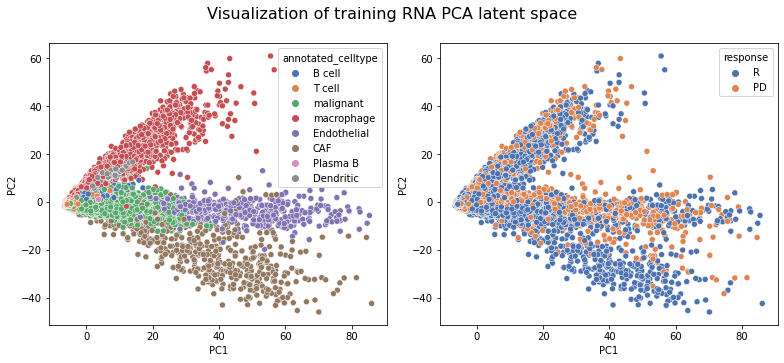

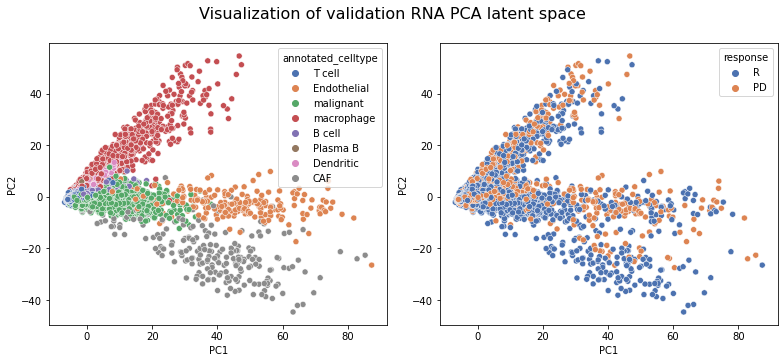

In [86]:
type_specific_pca(joint_history_train, joint_history_val, test_y, 29, "RNA")

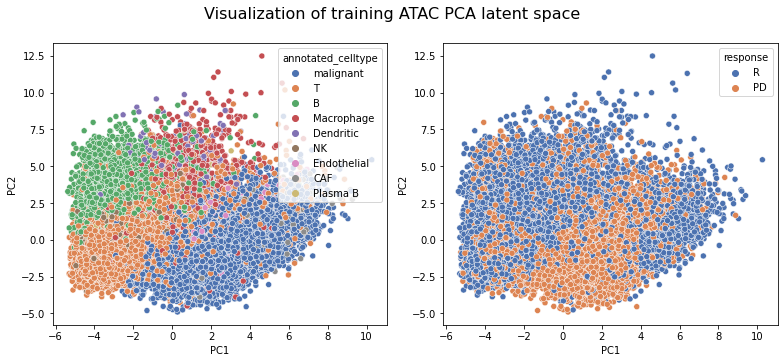

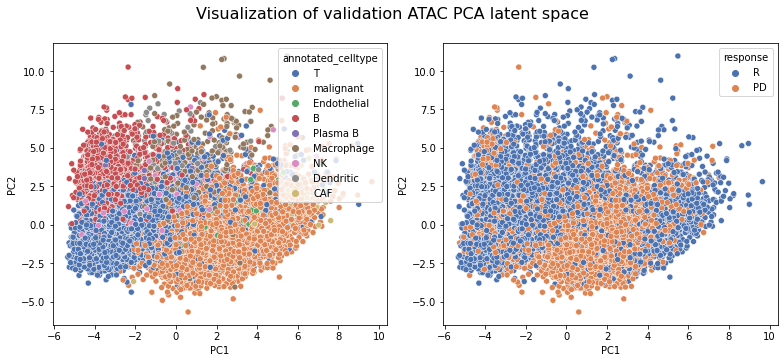

In [87]:
type_specific_pca(joint_history_train, joint_history_val, test_y, 29, "ATAC")

In [88]:
num_epochs=30
batch_size=128
n_latent=50


ae_joint_model = joint_initialize_model(rna_x = None, atac_x = None, 
                                     n_latent = 50, optimizer ='Adam',
                                     learning_rate = 1e-4, 
                                     lambda_latent = 1e-2, 
                                     lambda_reconst = 1, 
                                     model_type='joint_ae', joint_matrix = common_matrix)

ae_joint_history_train , ae_joint_history_val , ae_joint_history_weight= ae_singular_train(ae_joint_model, 
                                                                                           x_train, y_train,
                                                                                           test_x, test_y,
                                                                                           num_epochs,
                                                                                           batch_size, sparse=False)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 452.336181640625, Validation loss: 503.6786193847656
Epoch: 1, Train loss: 539.2427368164062, Validation loss: 465.4200439453125
Epoch: 2, Train loss: 395.09027099609375, Validation loss: 441.0479736328125
Epoch: 3, Train loss: 540.4201049804688, Validation loss: 424.3227844238281
Epoch: 4, Train loss: 409.9212951660156, Validation loss: 412.53045654296875
Epoch: 5, Train loss: 295.6451416015625, Validation loss: 403.3898010253906
Epoch: 6, Train loss: 504.53961181640625, Validation loss: 396.483154296875
Epoch: 7, Train loss: 418.4754333496094, Validation loss: 390.36322021484375
Epoch: 8, Train loss: 375.6883544921875, Validation loss: 385.7492370605469
Epoch: 9, Train loss: 252.4532470703125, Validation loss: 381.56536865234375
Epoch: 10, Train loss: 550.156005859375, Validation loss: 378.1536865234375
Epoch: 11, Train loss: 387.1988830566406, Validation loss: 375.18182373046875
Epoch: 12, Train loss: 349.88922119140625, Validation loss: 372.5569763183594
Epoch

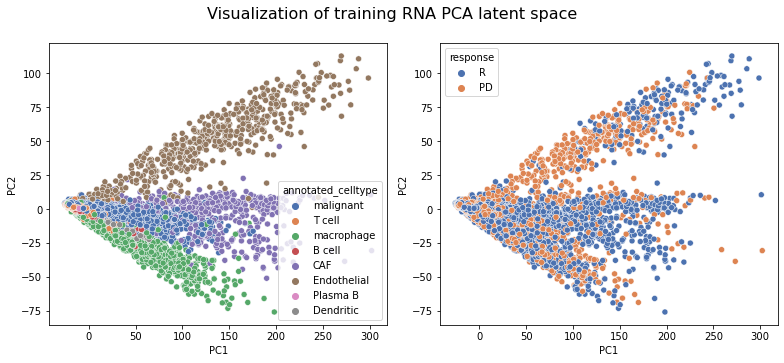

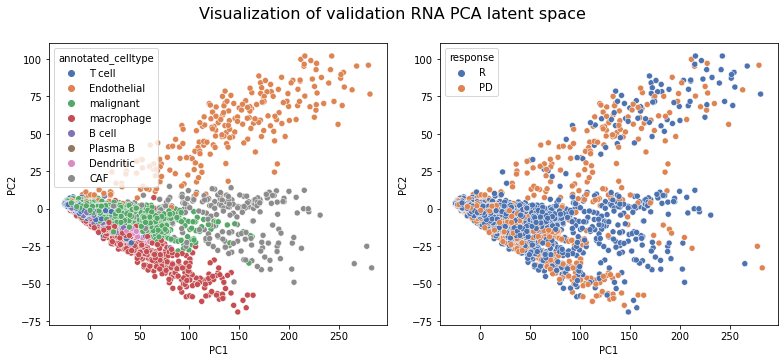

In [90]:
type_specific_pca(ae_joint_history_train, ae_joint_history_val, test_y, 29, "RNA")

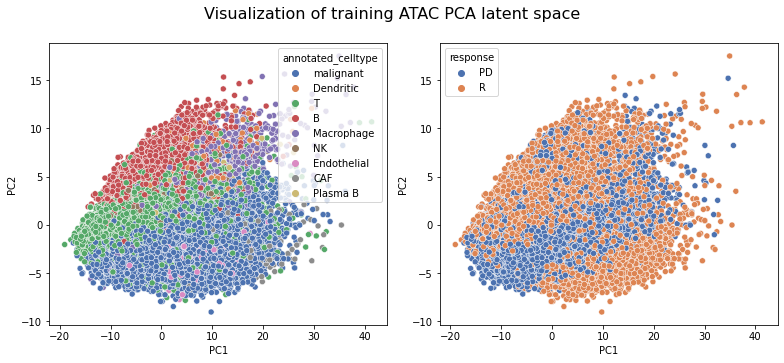

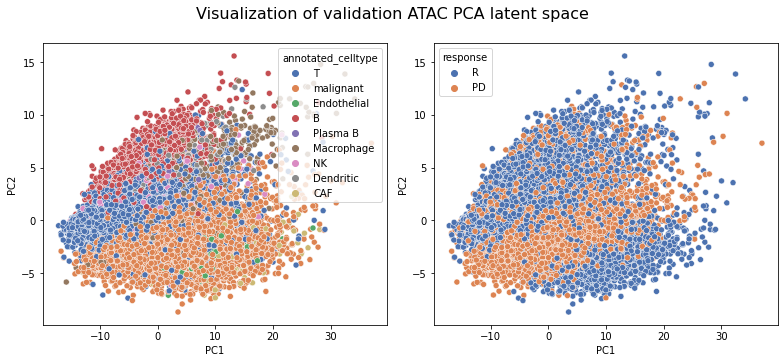

In [91]:
type_specific_pca(ae_joint_history_train, ae_joint_history_val, test_y, 29, "ATAC")

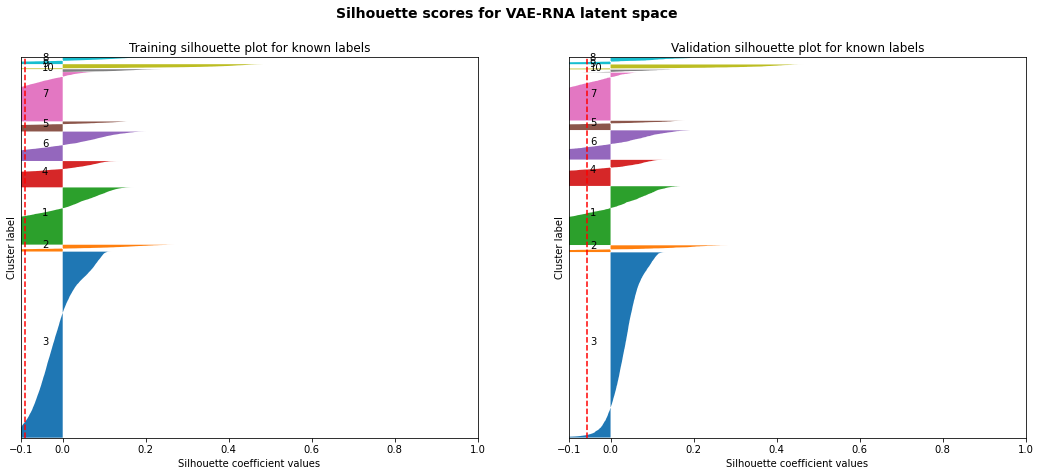

In [94]:
type_specific_silhouette(joint_history_train, joint_history_val, test_y , 29, 'VAE-RNA', 'RNA')

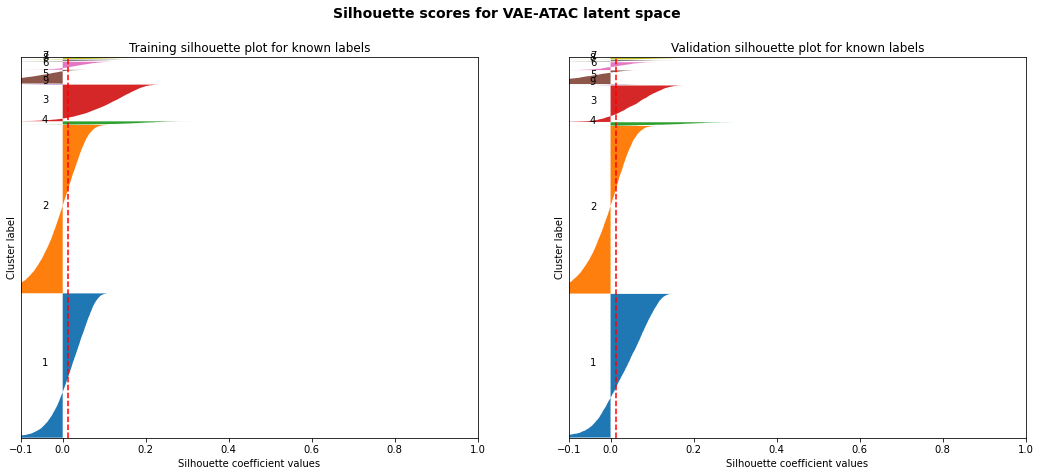

In [95]:
type_specific_silhouette(joint_history_train, joint_history_val, test_y , 29, 'VAE-ATAC', 'ATAC')

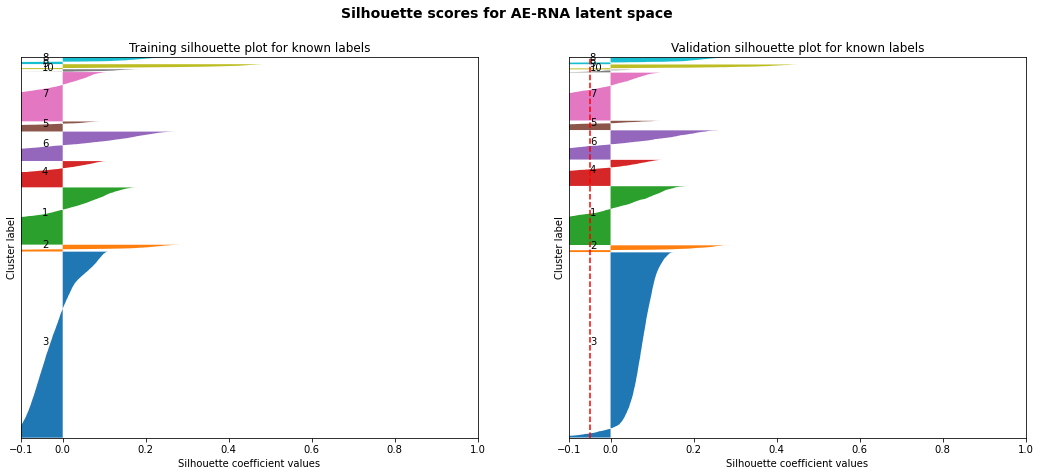

In [96]:
type_specific_silhouette(ae_joint_history_train, ae_joint_history_val, test_y , 29, 'AE-RNA', 'RNA')

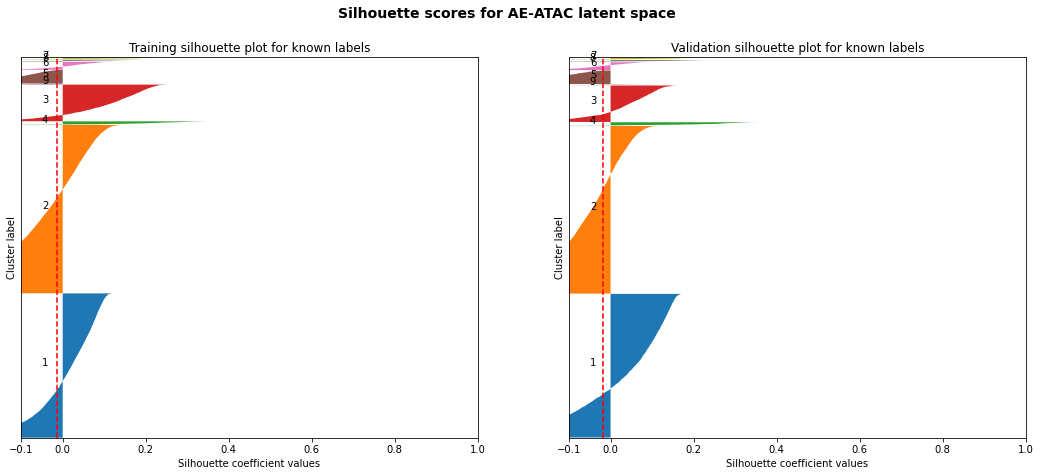

In [97]:
type_specific_silhouette(ae_joint_history_train, ae_joint_history_val, test_y , 29, 'AE-ATAC', 'ATAC')

<ipython-input-98-9aa67232b797>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_adata.obs['annotation'] = pd.Categorical(train_adata.obs['annotation'])
<ipython-input-98-9aa67232b797>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_adata.obs['annotated_celltype'] = pd.Categorical(train_adata.obs['annotated_celltype'])
<ipython-input-98-9aa67232b797>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

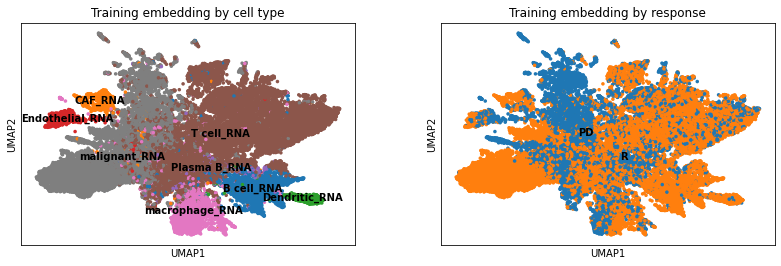

<ipython-input-98-9aa67232b797>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['annotation'] = pd.Categorical(val_adata.obs['annotation'])
<ipython-input-98-9aa67232b797>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['annotated_celltype'] = pd.Categorical(val_adata.obs['annotated_celltype'])
<ipython-input-98-9aa67232b797>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


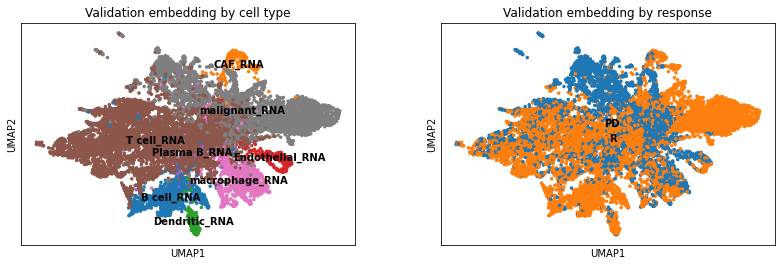

In [99]:
type_specific_joint_latent(joint_history_train, joint_history_val, test_y , 29, "RNA")

<ipython-input-98-9aa67232b797>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_adata.obs['annotation'] = pd.Categorical(train_adata.obs['annotation'])
<ipython-input-98-9aa67232b797>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_adata.obs['annotated_celltype'] = pd.Categorical(train_adata.obs['annotated_celltype'])
<ipython-input-98-9aa67232b797>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

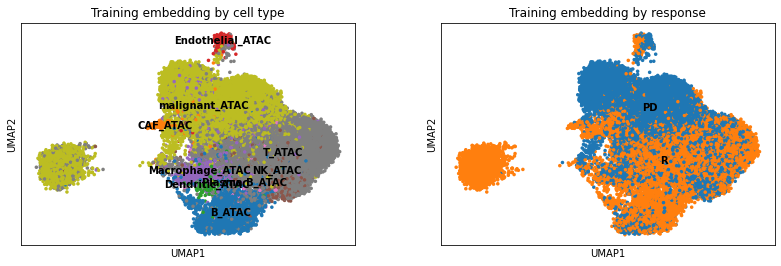

<ipython-input-98-9aa67232b797>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['annotation'] = pd.Categorical(val_adata.obs['annotation'])
<ipython-input-98-9aa67232b797>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_adata.obs['annotated_celltype'] = pd.Categorical(val_adata.obs['annotated_celltype'])
<ipython-input-98-9aa67232b797>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


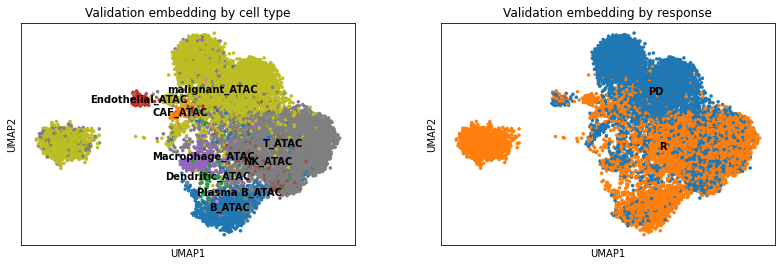

In [100]:
type_specific_joint_latent(joint_history_train, joint_history_val, test_y , 29, "ATAC")

### AE vs VAE RNA alone 

In [13]:
validation_percent = 0.3
x_train, test_x, y_train, test_y  = train_test_split(mit_data.X, 
                                                     mit_data.obs,
                                                     test_size=validation_percent,
                                                     stratify = mit_data.obs['dbscan'])

In [14]:
### Alter latent coefficient 

model = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 1e-1, 
                               lambda_reconst = 1, 
                               model_type='singular_rna', joint_matrix = None)


num_epochs=30
batch_size=64
n_latent=50

history_train , history_val , history_weight= singular_train(model, 
                                                             x_train, y_train, 
                                                             test_x, test_y, 
                                                             
                                                             num_epochs,
                                                             batch_size, sparse=False)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 7242.8759765625, Validation loss: 6590.56201171875
Epoch: 1, Train loss: 5789.99560546875, Validation loss: 6116.0361328125
Epoch: 2, Train loss: 6459.00830078125, Validation loss: 5849.78466796875
Epoch: 3, Train loss: 4766.6337890625, Validation loss: 5738.33935546875
Epoch: 4, Train loss: 5265.1748046875, Validation loss: 5660.80712890625
Epoch: 5, Train loss: 5959.654296875, Validation loss: 5578.7314453125
Epoch: 6, Train loss: 5503.34375, Validation loss: 5506.06640625
Epoch: 7, Train loss: 4920.32568359375, Validation loss: 5450.13134765625
Epoch: 8, Train loss: 5804.431640625, Validation loss: 5400.12939453125
Epoch: 9, Train loss: 5928.92724609375, Validation loss: 5354.95947265625
Epoch: 10, Train loss: 5139.8828125, Validation loss: 5313.13427734375
Epoch: 11, Train loss: 4804.65576171875, Validation loss: 5275.9365234375
Epoch: 12, Train loss: 4545.67236328125, Validation loss: 5240.9814453125
Epoch: 13, Train loss: 5752.4599609375, Validation loss: 52

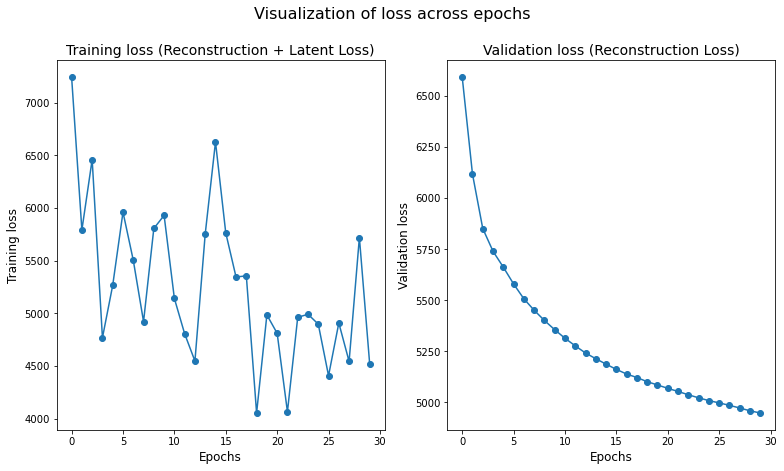

In [15]:
scRNA_loss(history_train, history_val)

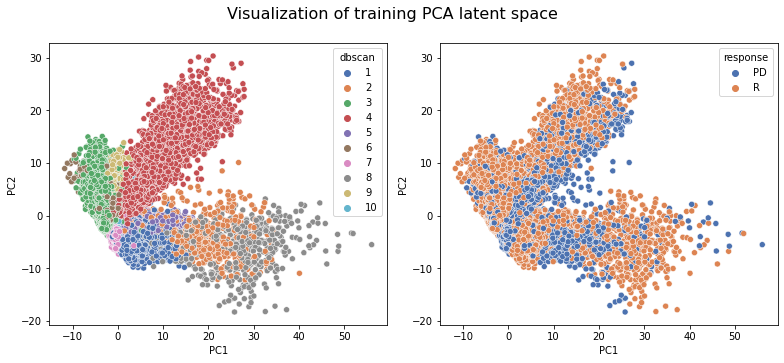

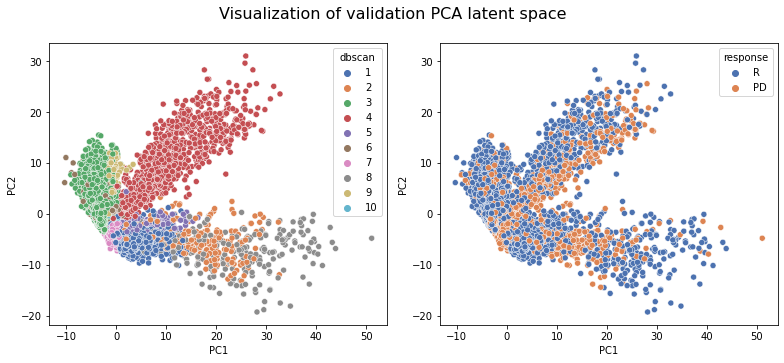

In [16]:
scRNA_latent_pca(history_train, history_val, test_y , num_epochs-1)

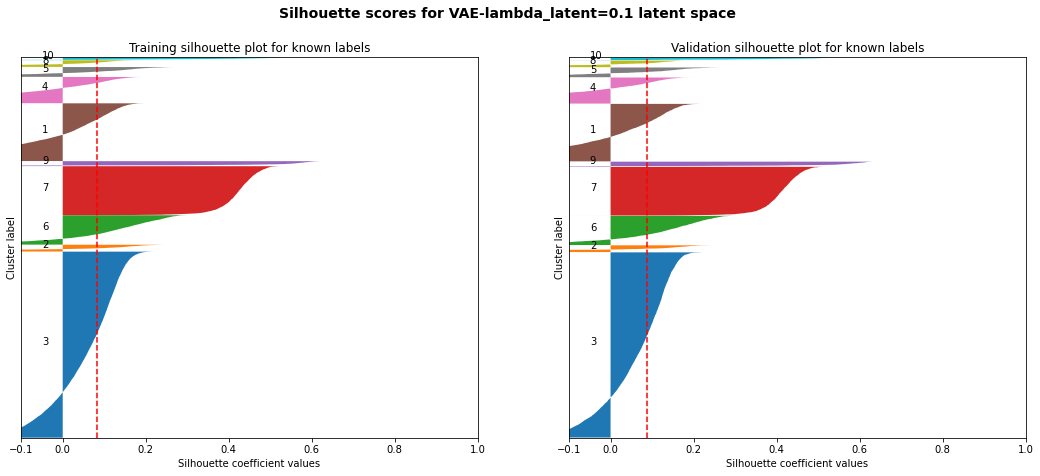

In [17]:
scRNA_silhouette(history_train, history_val, test_y , num_epochs-1, 'VAE-lambda_latent=0.1')

... storing 'orig.ident' as categorical


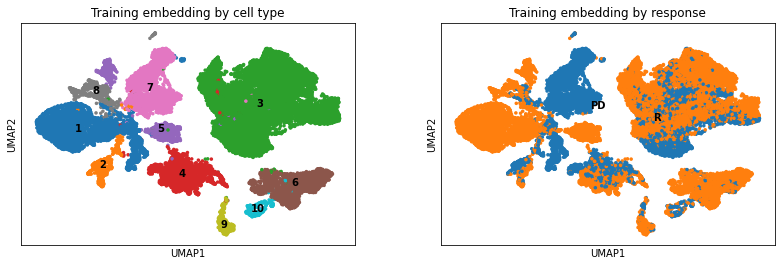

... storing 'orig.ident' as categorical


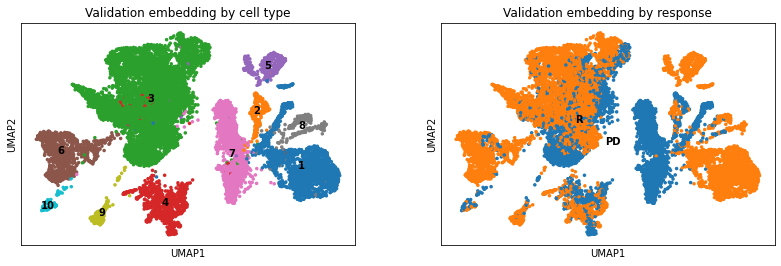

In [22]:
scRNA_latent(history_train, history_val, test_y , num_epochs-1)

In [18]:
### Alter latent coefficient 
#https://openreview.net/pdf?id=Sy2fzU9gl
model_4 = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 4, 
                               lambda_reconst = 1, 
                               model_type='singular_rna', joint_matrix = None)


num_epochs=30
batch_size=64
n_latent=50

history_train_4 , history_val_4 , history_weight_4= singular_train(model_4, 
                                                             x_train, y_train, 
                                                             test_x, test_y, 
                                                             
                                                             num_epochs,
                                                             batch_size, sparse=False)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 8597.8623046875, Validation loss: 8002.1240234375
Epoch: 1, Train loss: 5762.72119140625, Validation loss: 6839.1015625
Epoch: 2, Train loss: 7985.7373046875, Validation loss: 6565.97802734375
Epoch: 3, Train loss: 5283.96240234375, Validation loss: 6441.30322265625
Epoch: 4, Train loss: 6798.50830078125, Validation loss: 6311.98876953125
Epoch: 5, Train loss: 5011.283203125, Validation loss: 6199.228515625
Epoch: 6, Train loss: 7633.22314453125, Validation loss: 6112.2900390625
Epoch: 7, Train loss: 5248.66015625, Validation loss: 6034.53955078125
Epoch: 8, Train loss: 6264.546875, Validation loss: 5967.0888671875
Epoch: 9, Train loss: 6268.396484375, Validation loss: 5914.88330078125
Epoch: 10, Train loss: 7699.39990234375, Validation loss: 5865.4755859375
Epoch: 11, Train loss: 5289.54931640625, Validation loss: 5819.322265625
Epoch: 12, Train loss: 6748.6845703125, Validation loss: 5778.70361328125
Epoch: 13, Train loss: 6428.796875, Validation loss: 5738.9125

In [24]:
model_10 = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 10, 
                               lambda_reconst = 1, 
                               model_type='singular_rna', joint_matrix = None)


num_epochs=30
batch_size=64
n_latent=50

history_train_10 , history_val_10 , history_weight_10= singular_train(model_10, 
                                                             x_train, y_train, 
                                                             test_x, test_y, 
                                                             
                                                             num_epochs,
                                                             batch_size, sparse=False)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 12031.7294921875, Validation loss: 8547.7333984375
Epoch: 1, Train loss: 10678.73046875, Validation loss: 8543.6962890625
Epoch: 2, Train loss: 8376.634765625, Validation loss: 8543.2265625
Epoch: 3, Train loss: 9181.45703125, Validation loss: 8543.076171875
Epoch: 4, Train loss: 8462.56640625, Validation loss: 8543.0234375
Epoch: 5, Train loss: 9784.6630859375, Validation loss: 8543.0322265625
Epoch: 6, Train loss: 10155.220703125, Validation loss: 8543.03125
Epoch: 7, Train loss: 9800.763671875, Validation loss: 8543.044921875
Epoch: 8, Train loss: 7230.2822265625, Validation loss: 8543.048828125
Epoch: 9, Train loss: 7177.84912109375, Validation loss: 8543.05078125
Epoch: 10, Train loss: 8147.50927734375, Validation loss: 8543.0595703125
Epoch: 11, Train loss: 7930.4013671875, Validation loss: 8543.0693359375
Epoch: 12, Train loss: 8324.72265625, Validation loss: 8543.072265625
Epoch: 13, Train loss: 8024.005859375, Validation loss: 8543.080078125
Epoch: 14, Tr

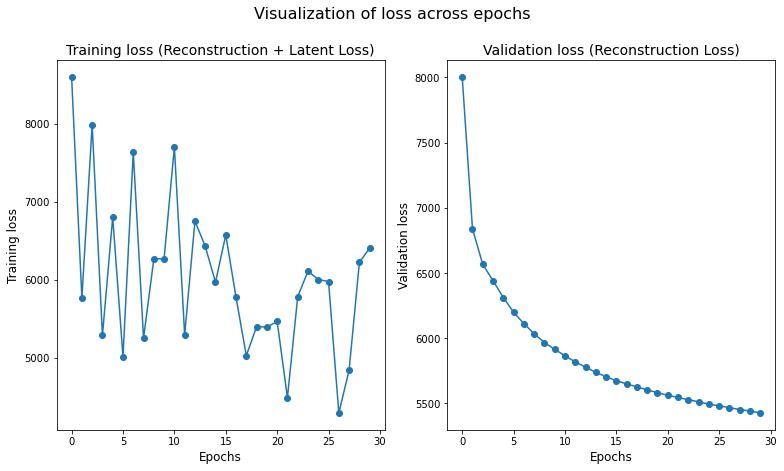

In [19]:
scRNA_loss(history_train_4, history_val_4)

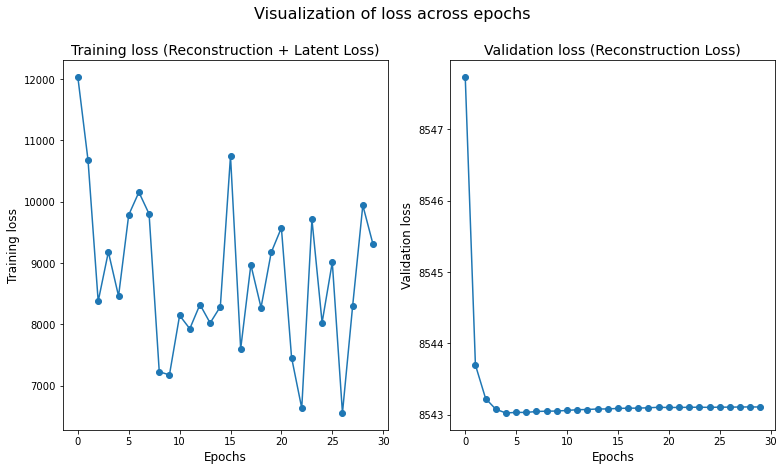

In [25]:
scRNA_loss(history_train_10, history_val_10)

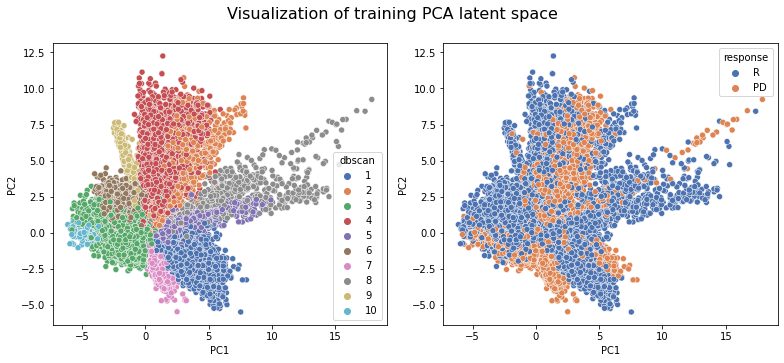

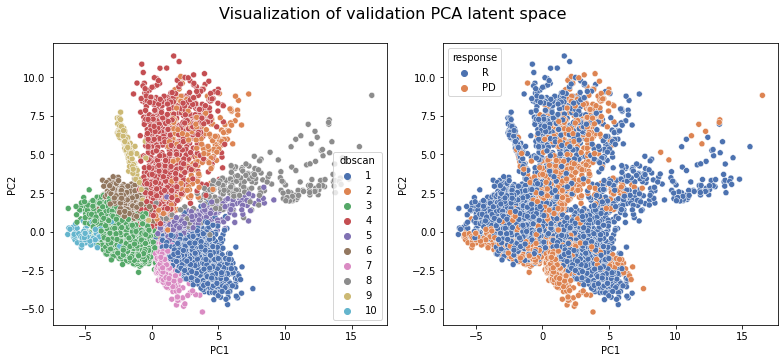

In [20]:
scRNA_latent_pca(history_train_4, history_val_4, test_y , num_epochs-1)

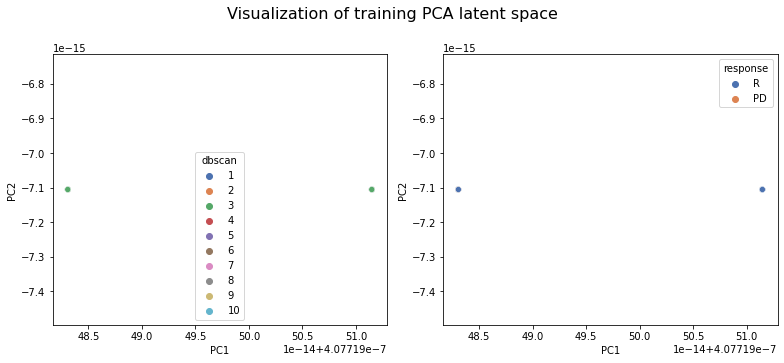

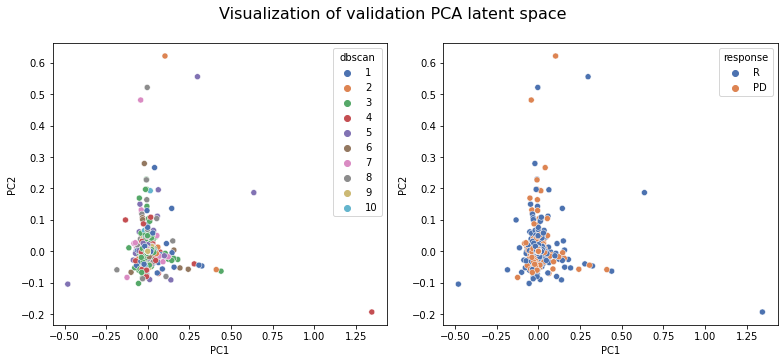

In [26]:
scRNA_latent_pca(history_train_10, history_val_10, test_y , num_epochs-1)

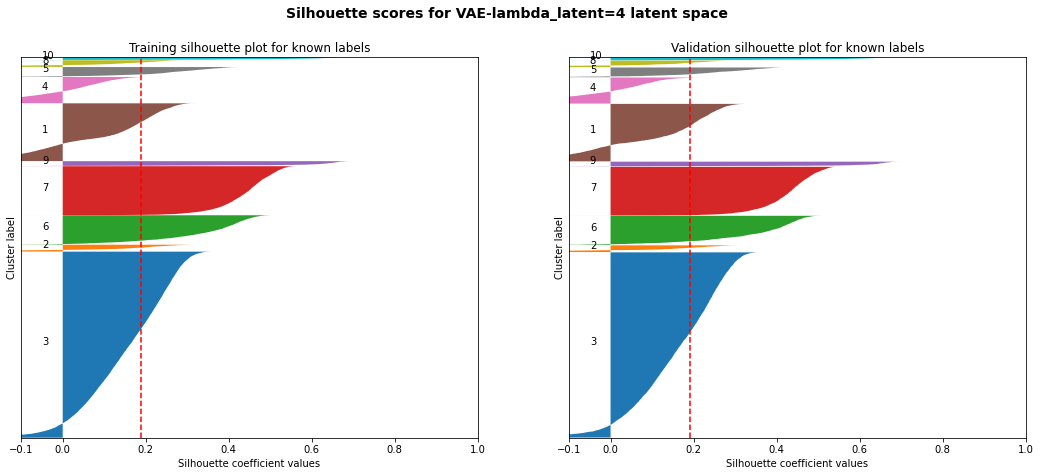

In [27]:
scRNA_silhouette(history_train_4, history_val_4, test_y , num_epochs-1, 'VAE-lambda_latent=4')

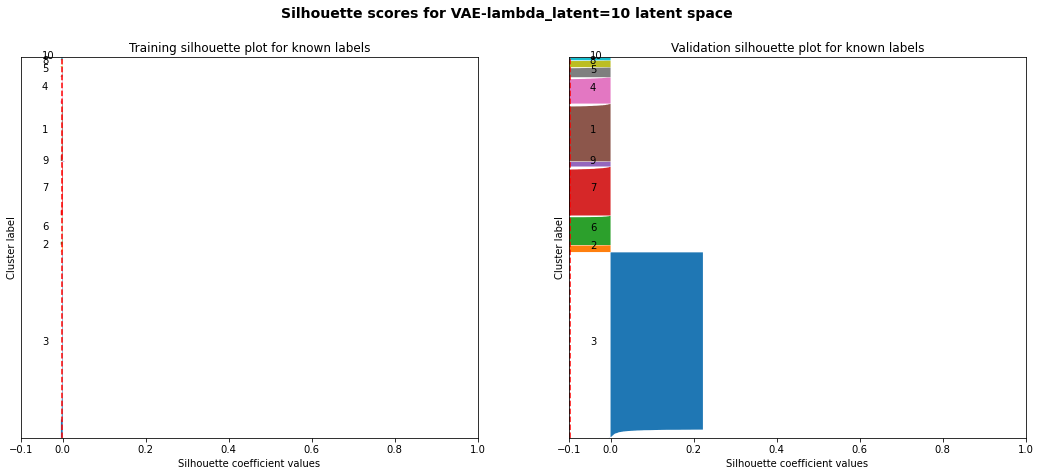

In [28]:
scRNA_silhouette(history_train_10, history_val_10, test_y , num_epochs-1, 'VAE-lambda_latent=10')

... storing 'orig.ident' as categorical


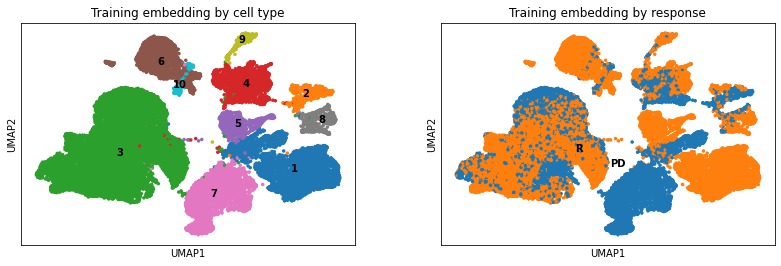

... storing 'orig.ident' as categorical


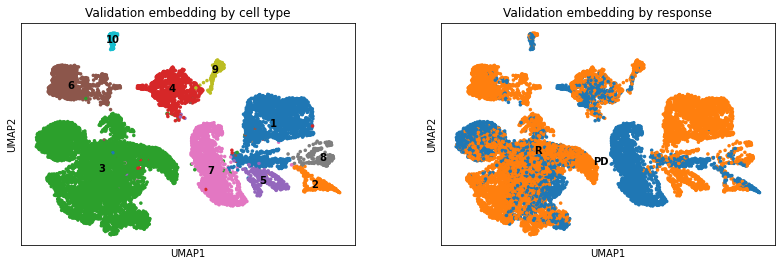

In [23]:
scRNA_latent(history_train_4, history_val_4, test_y , num_epochs-1)

... storing 'orig.ident' as categorical


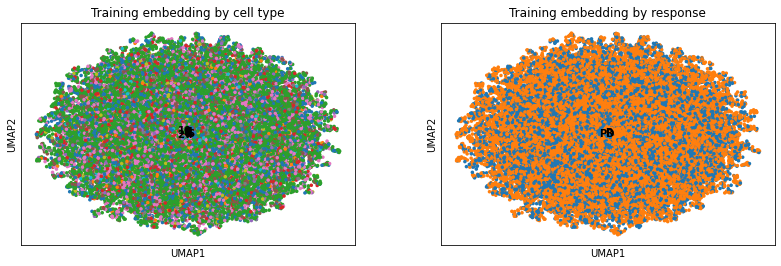

... storing 'orig.ident' as categorical


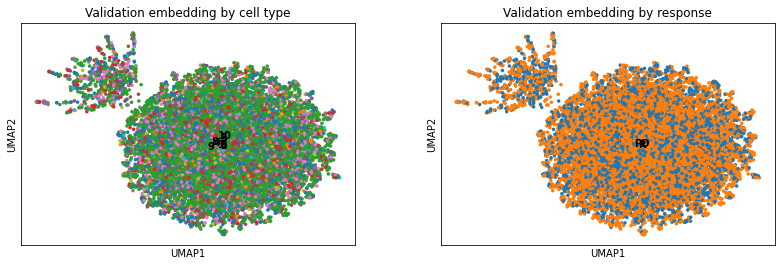

In [29]:
scRNA_latent(history_train_10, history_val_10, test_y , num_epochs-1)

In [45]:
### VAE model 

model = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 1e-2, 
                               lambda_reconst = 1, 
                               model_type='singular_rna', joint_matrix = None)


num_epochs=30
batch_size=64
n_latent=50

history_train , history_val , history_weight= singular_train(model, 
                                                             x_train, y_train, 
                                                             test_x, test_y, 
                                                             
                                                             num_epochs,
                                                             batch_size, sparse=False)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 9582.1591796875, Validation loss: 6975.33984375
Epoch: 1, Train loss: 6172.27294921875, Validation loss: 6345.6640625
Epoch: 2, Train loss: 6709.86865234375, Validation loss: 6000.5576171875
Epoch: 3, Train loss: 5865.22021484375, Validation loss: 5833.30029296875
Epoch: 4, Train loss: 5048.86376953125, Validation loss: 5732.06201171875
Epoch: 5, Train loss: 5385.07666015625, Validation loss: 5654.24658203125
Epoch: 6, Train loss: 5924.7822265625, Validation loss: 5581.10546875
Epoch: 7, Train loss: 5128.67822265625, Validation loss: 5515.1005859375
Epoch: 8, Train loss: 5742.8349609375, Validation loss: 5463.40576171875
Epoch: 9, Train loss: 4274.37744140625, Validation loss: 5418.90771484375
Epoch: 10, Train loss: 6007.8505859375, Validation loss: 5376.99267578125
Epoch: 11, Train loss: 5331.1904296875, Validation loss: 5334.41796875
Epoch: 12, Train loss: 4754.70556640625, Validation loss: 5296.353515625
Epoch: 13, Train loss: 5728.154296875, Validation loss: 5

In [46]:
### AE model 

ae_model = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 1e-2, 
                                  
                               lambda_reconst = 1, 
                               model_type='singular_rna_ae', joint_matrix = None)


num_epochs=30
batch_size=64
n_latent=50

ae_history_train , ae_history_val , ae_history_weight= ae_singular_train(ae_model, 
                                                                         x_train, y_train, 
                                                                         test_x, test_y, 
                                                                         num_epochs,
                                                                         batch_size, sparse=False)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 6912.970703125, Validation loss: 6468.48095703125
Epoch: 1, Train loss: 5932.1640625, Validation loss: 6010.87255859375
Epoch: 2, Train loss: 5356.04296875, Validation loss: 5802.52197265625
Epoch: 3, Train loss: 5233.341796875, Validation loss: 5708.84375
Epoch: 4, Train loss: 4444.90966796875, Validation loss: 5637.56494140625
Epoch: 5, Train loss: 5050.29296875, Validation loss: 5574.67431640625
Epoch: 6, Train loss: 5632.49072265625, Validation loss: 5501.779296875
Epoch: 7, Train loss: 6176.76171875, Validation loss: 5424.64111328125
Epoch: 8, Train loss: 4753.85205078125, Validation loss: 5362.35595703125
Epoch: 9, Train loss: 5246.552734375, Validation loss: 5305.990234375
Epoch: 10, Train loss: 5177.50634765625, Validation loss: 5258.5126953125
Epoch: 11, Train loss: 5326.4375, Validation loss: 5217.70068359375
Epoch: 12, Train loss: 5563.77685546875, Validation loss: 5184.6162109375
Epoch: 13, Train loss: 4978.1220703125, Validation loss: 5152.3447265625


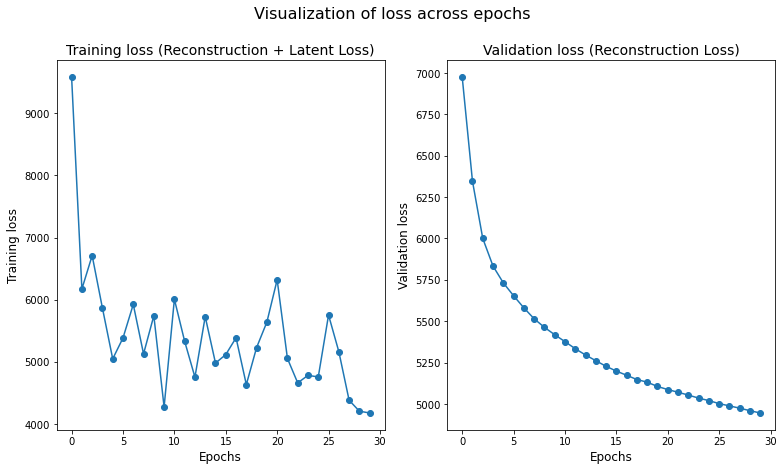

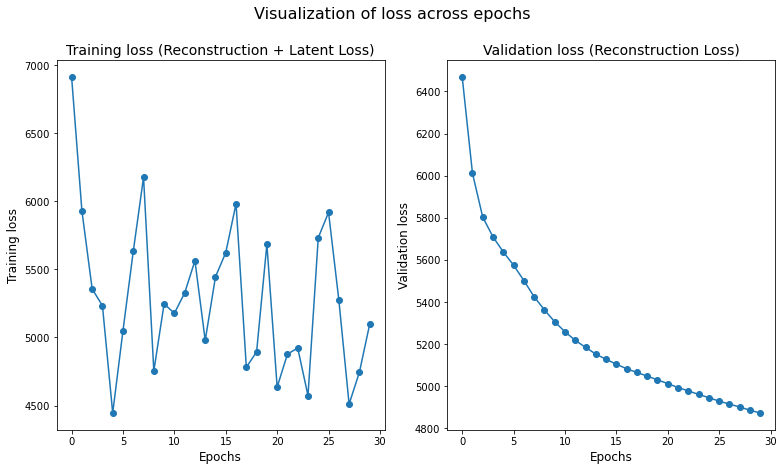

In [47]:
scRNA_loss(history_train, history_val)
scRNA_loss(ae_history_train, ae_history_val)

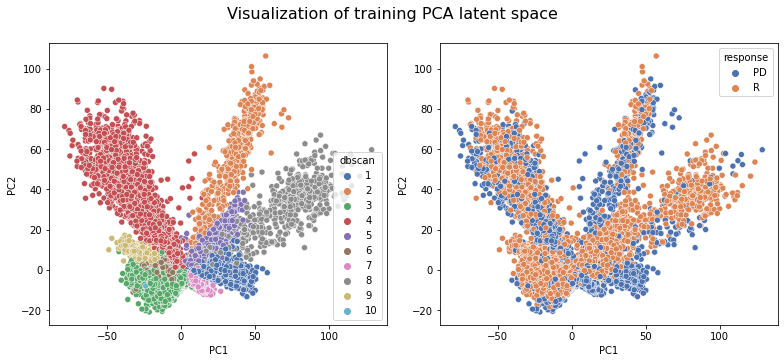

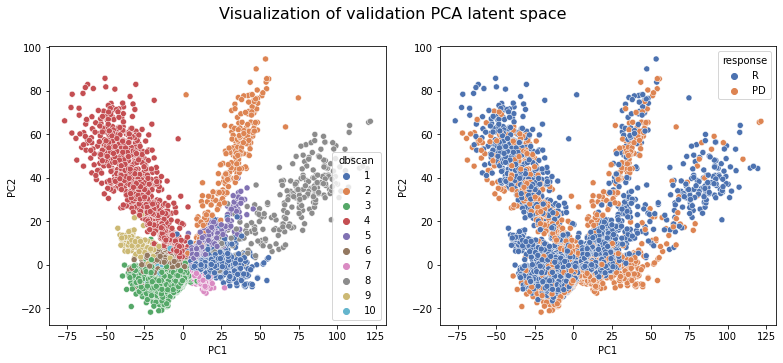

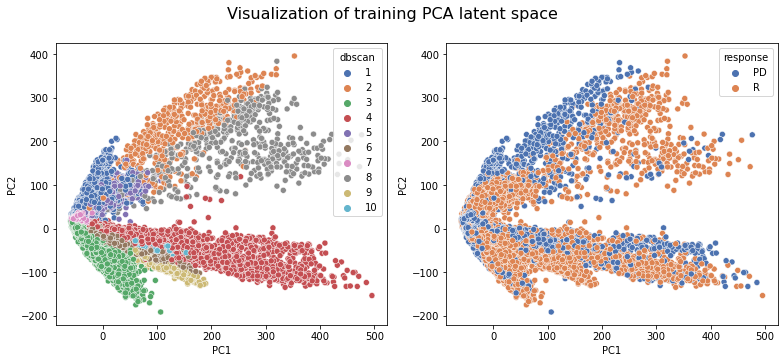

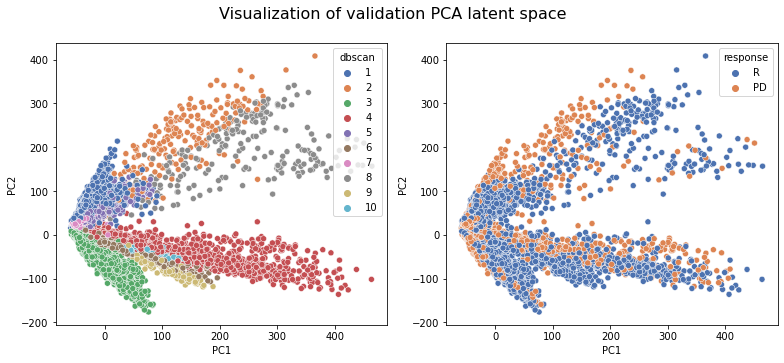

In [48]:
scRNA_latent_pca(history_train, history_val, test_y , num_epochs-1)
scRNA_latent_pca(ae_history_train, ae_history_val, test_y , num_epochs-1)

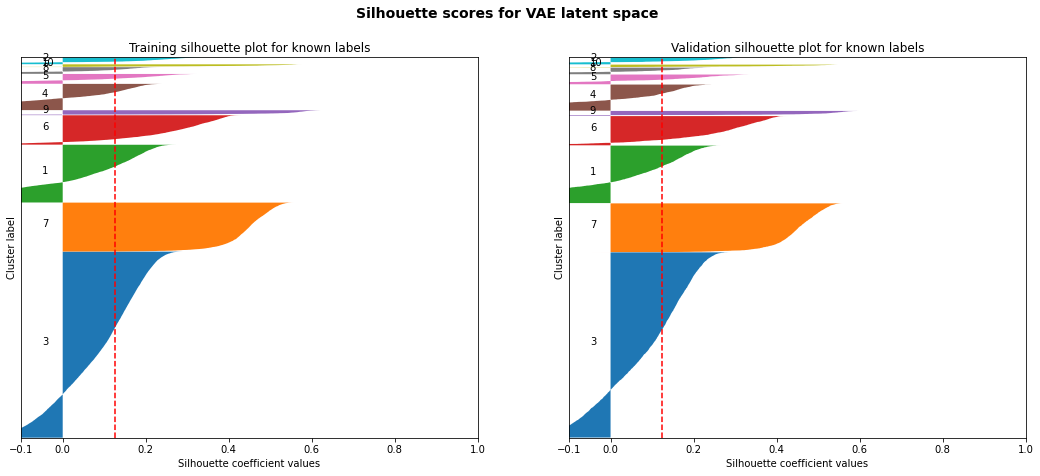

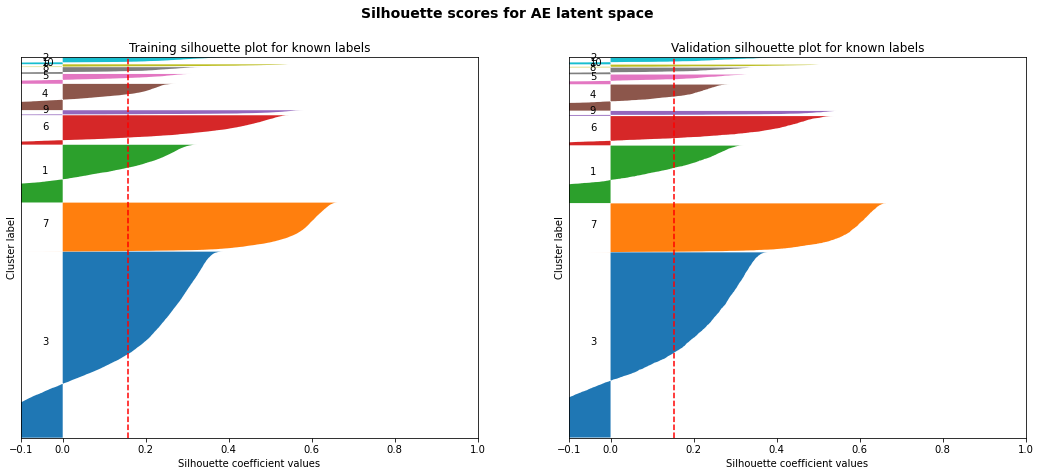

In [49]:
scRNA_silhouette(history_train, history_val, test_y , num_epochs-1, 'VAE')
scRNA_silhouette(ae_history_train, ae_history_val, test_y , num_epochs-1, 'AE')

### Model train on subset of data with three categories

In [32]:
subset = mit_data[ (mit_data.obs['dbscan']==3) |(mit_data.obs['dbscan']==4) | (mit_data.obs['dbscan']==6) ,:]
validation_percent = 0.3
x_train, test_x, y_train, test_y  = train_test_split(subset.X, 
                                                     subset.obs,
                                                     test_size=validation_percent,
                                                     stratify = subset.obs['dbscan'])

In [35]:
### VAE model 

model = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 1e-2, 
                               lambda_reconst = 1, 
                               model_type='singular_rna', joint_matrix = None)


num_epochs=30
batch_size=64
n_latent=50

history_train , history_val , history_weight= singular_train(model, 
                                                             x_train, y_train, 
                                                             test_x, test_y, 
                                                             
                                                             num_epochs,
                                                             batch_size, sparse=True)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 4497.71142578125, Validation loss: 5305.943359375
Epoch: 1, Train loss: 4419.0546875, Validation loss: 4894.837890625
Epoch: 2, Train loss: 3819.904541015625, Validation loss: 4705.43896484375
Epoch: 3, Train loss: 5209.03564453125, Validation loss: 4590.69384765625
Epoch: 4, Train loss: 3960.28955078125, Validation loss: 4504.24951171875
Epoch: 5, Train loss: 4024.17333984375, Validation loss: 4425.65185546875
Epoch: 6, Train loss: 4288.25927734375, Validation loss: 4372.037109375
Epoch: 7, Train loss: 4889.87158203125, Validation loss: 4322.98876953125
Epoch: 8, Train loss: 4678.00244140625, Validation loss: 4277.93017578125
Epoch: 9, Train loss: 3747.3466796875, Validation loss: 4230.4765625
Epoch: 10, Train loss: 3713.990478515625, Validation loss: 4181.193359375
Epoch: 11, Train loss: 4045.82373046875, Validation loss: 4139.2685546875
Epoch: 12, Train loss: 4575.70703125, Validation loss: 4104.4013671875
Epoch: 13, Train loss: 4073.164306640625, Validation lo

In [38]:
### AE model 

ae_model = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 1e-2, 
                                  
                               lambda_reconst = 1, 
                               model_type='singular_rna_ae', joint_matrix = None)


num_epochs=30
batch_size=64
n_latent=50

ae_history_train , ae_history_val , ae_history_weight= ae_singular_train(ae_model, 
                                                                      x_train, y_train, 
                                                                      test_x, test_y, 
                                                                      num_epochs,
                                                                      batch_size, sparse=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 5831.60107421875, Validation loss: 5211.69140625
Epoch: 1, Train loss: 4816.3271484375, Validation loss: 4876.34375
Epoch: 2, Train loss: 4384.9921875, Validation loss: 4653.9560546875
Epoch: 3, Train loss: 4083.85009765625, Validation loss: 4541.58642578125
Epoch: 4, Train loss: 3460.75390625, Validation loss: 4430.85498046875
Epoch: 5, Train loss: 3589.6689453125, Validation loss: 4351.02490234375
Epoch: 6, Train loss: 4923.001953125, Validation loss: 4303.3828125
Epoch: 7, Train loss: 4077.52490234375, Validation loss: 4265.2919921875
Epoch: 8, Train loss: 4320.6103515625, Validation loss: 4225.88134765625
Epoch: 9, Train loss: 4503.1103515625, Validation loss: 4185.76123046875
Epoch: 10, Train loss: 3637.41357421875, Validation loss: 4143.16015625
Epoch: 11, Train loss: 4699.599609375, Validation loss: 4106.45703125
Epoch: 12, Train loss: 4128.5595703125, Validation loss: 4072.230224609375
Epoch: 13, Train loss: 3874.1005859375, Validation loss: 4045.416748046

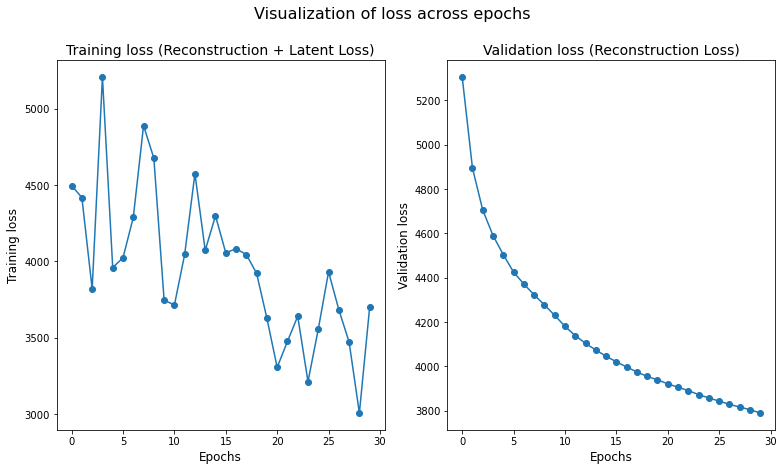

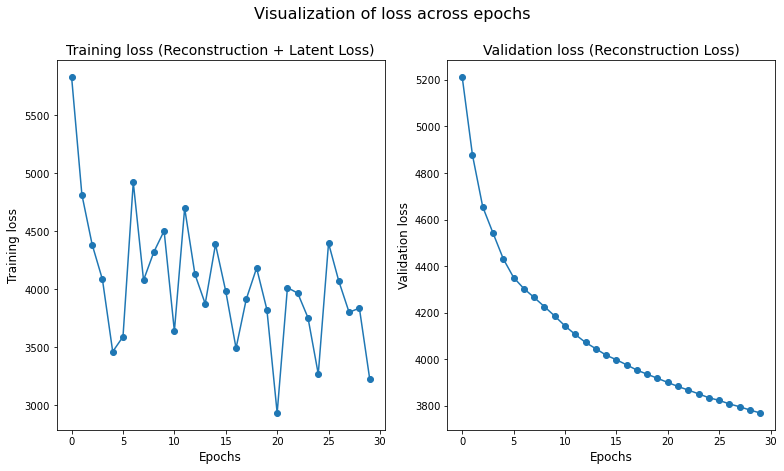

In [39]:
scRNA_loss(history_train, history_val)
scRNA_loss(ae_history_train, ae_history_val)

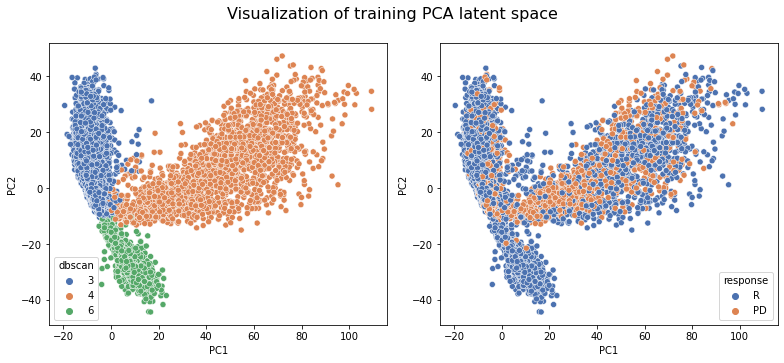

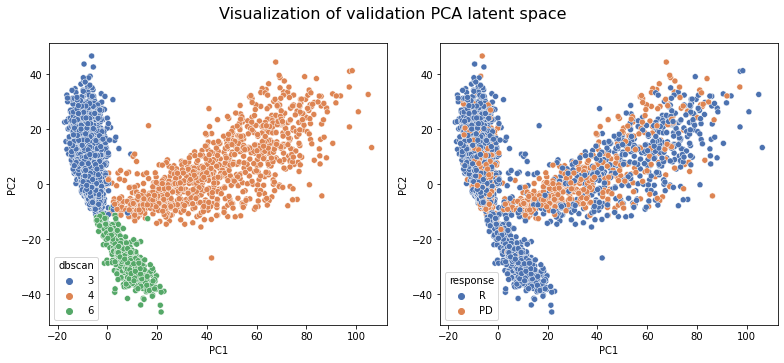

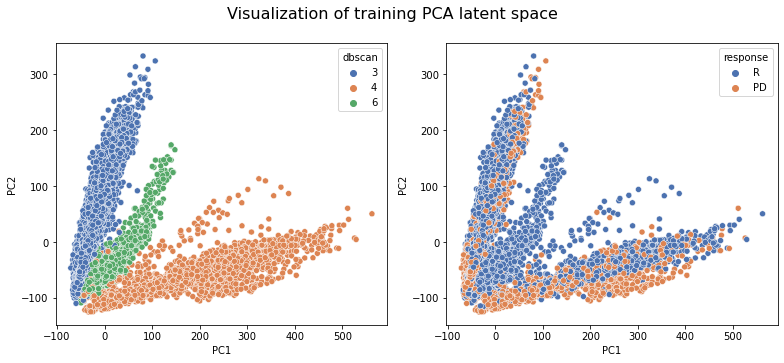

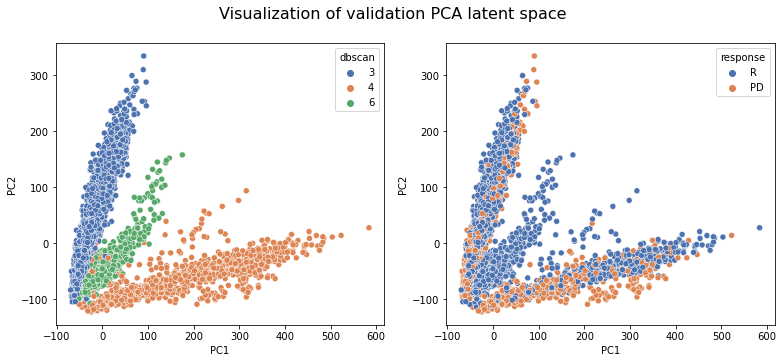

In [40]:
scRNA_latent_pca(history_train, history_val, test_y , num_epochs-1)
scRNA_latent_pca(ae_history_train, ae_history_val, test_y , num_epochs-1)

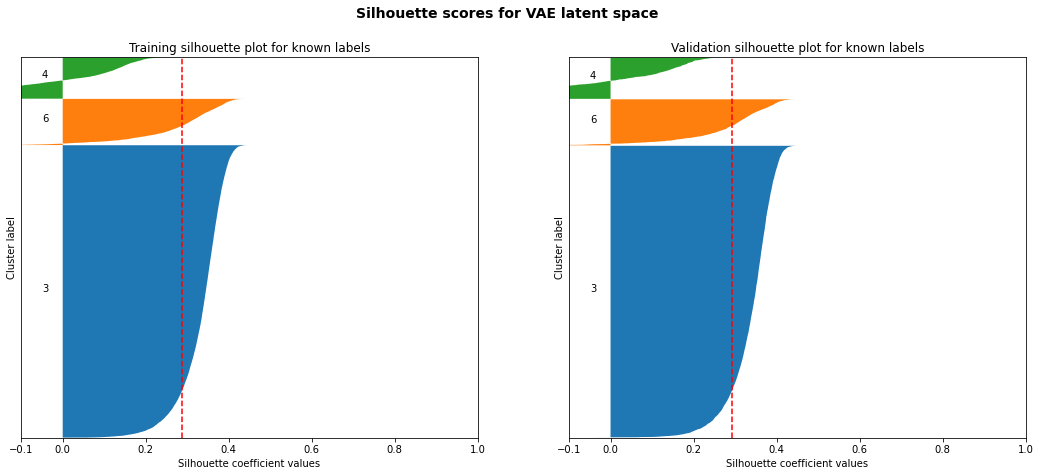

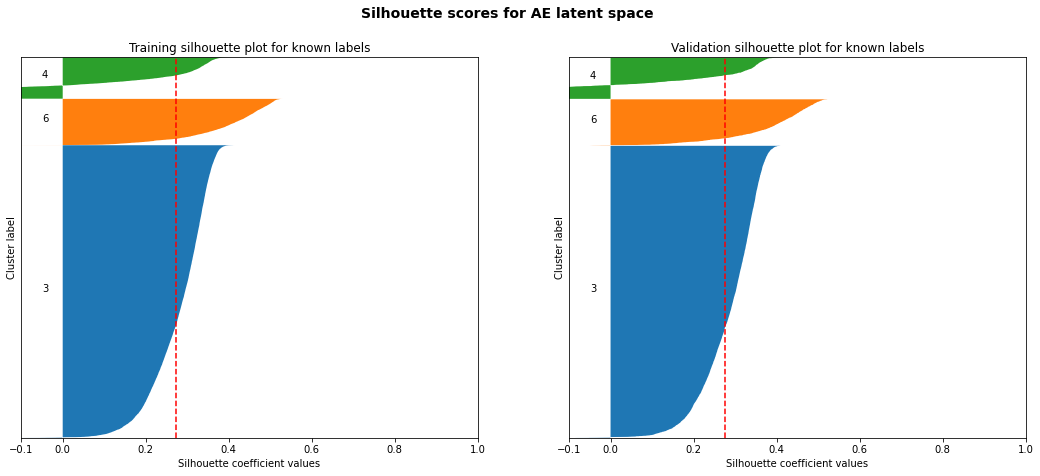

In [41]:
scRNA_silhouette(history_train, history_val, test_y , num_epochs-1, 'VAE')
scRNA_silhouette(ae_history_train, ae_history_val, test_y , num_epochs-1, 'AE')

### VAE vs AE single cell subset comparisons for 5 epochs

In [9]:
model = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 1e-2, 
                               lambda_reconst = 1, 
                               model_type='singular_rna', joint_matrix = None)

In [10]:
num_epochs=5
batch_size=64
n_latent=50

history_train , history_val , history_weight= singular_train(model, 
                                                             x_train, y_train, 
                                                             test_x, test_y, 
                                                             
                                                             num_epochs,
                                                             batch_size, sparse=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 4875.7392578125, Validation loss: 5357.6845703125
Epoch: 1, Train loss: 4668.94482421875, Validation loss: 5006.6455078125
Epoch: 2, Train loss: 3961.8232421875, Validation loss: 4762.04052734375
Epoch: 3, Train loss: 5475.8857421875, Validation loss: 4632.98583984375
Epoch: 4, Train loss: 4646.93359375, Validation loss: 4540.76025390625


In [18]:
ae_model = joint_initialize_model(rna_x = x_train, atac_x = None, 
                               
                               n_latent = 50, optimizer ='Adam',
                               learning_rate = 1e-4, 
                               lambda_latent = 1e-2, 
                                  
                               lambda_reconst = 1, 
                               model_type='singular_rna_ae', joint_matrix = None)


num_epochs=5
batch_size=64
n_latent=50

ae_history_train , ae_history_val , ae_history_weight= ae_singular_train(ae_model, 
                                                                      x_train, y_train, 
                                                                      test_x, test_y, 
                                                                      num_epochs,
                                                                      batch_size, sparse=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 0, Train loss: 5995.2802734375, Validation loss: 5173.11767578125
Epoch: 1, Train loss: 4453.5849609375, Validation loss: 4815.6689453125
Epoch: 2, Train loss: 4830.2861328125, Validation loss: 4668.681640625
Epoch: 3, Train loss: 5178.6884765625, Validation loss: 4598.9384765625
Epoch: 4, Train loss: 4517.25390625, Validation loss: 4529.3466796875


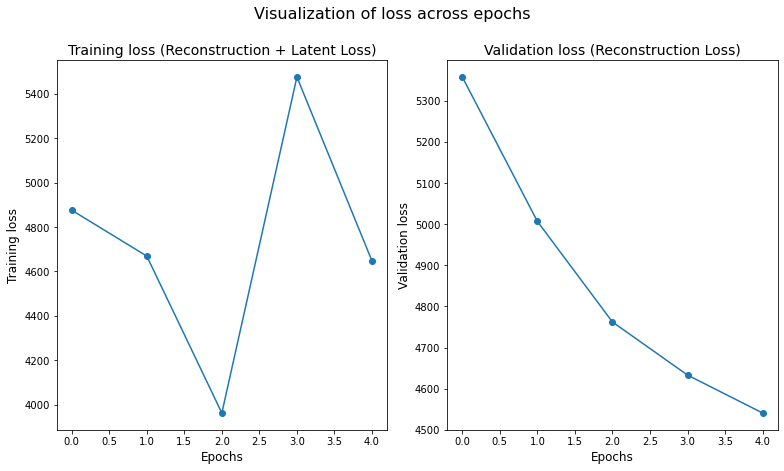

In [19]:
scRNA_loss(history_train, history_val)

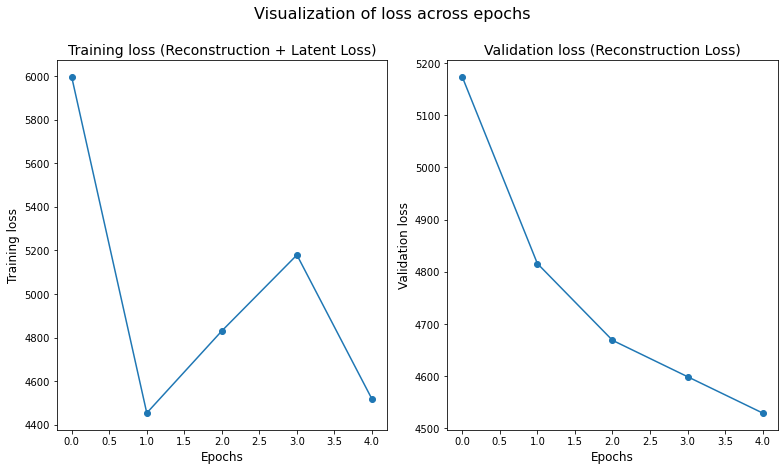

In [20]:
scRNA_loss(ae_history_train, ae_history_val)

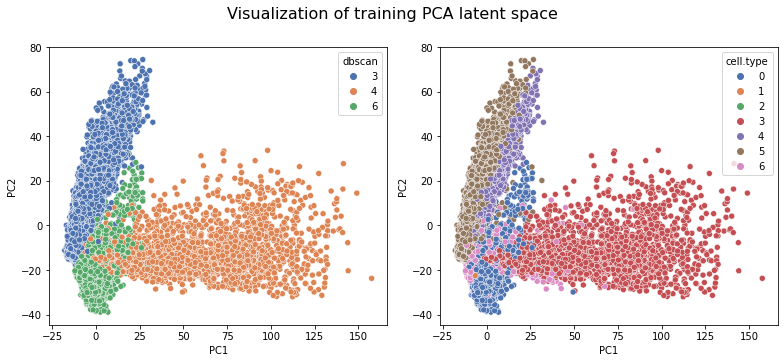

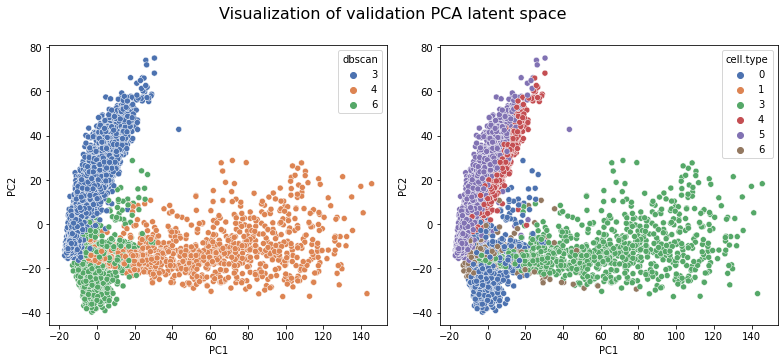

In [25]:
scRNA_latent_pca(history_train, history_val, test_y , 4)

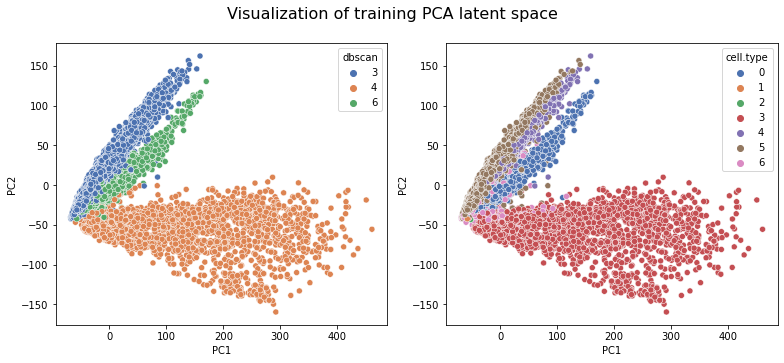

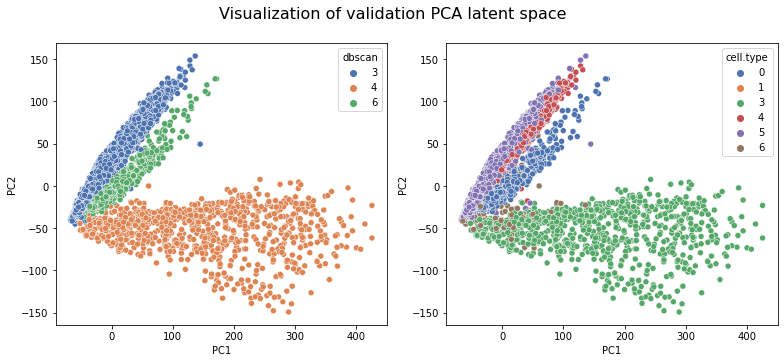

In [26]:
scRNA_latent_pca(ae_history_train, ae_history_val, test_y , 4)

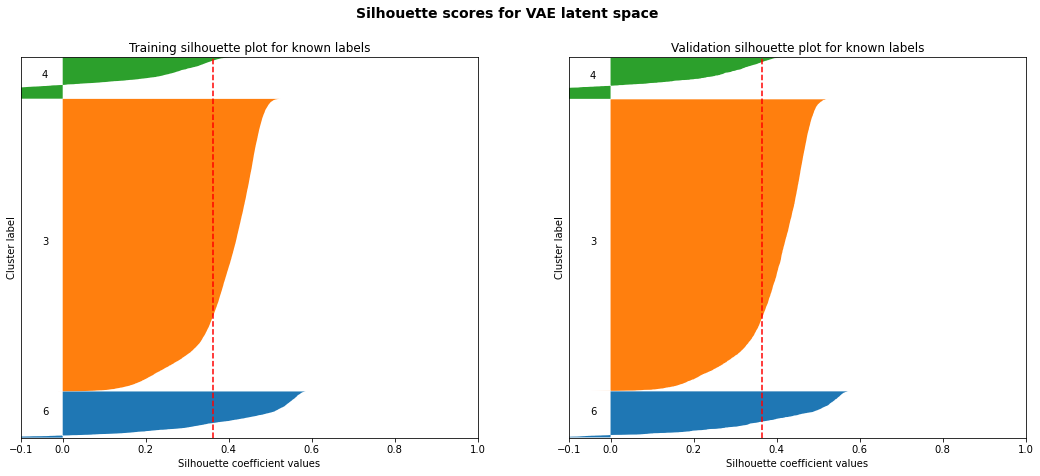

In [30]:
scRNA_silhouette(history_train, history_val, test_y , 4, 'VAE')

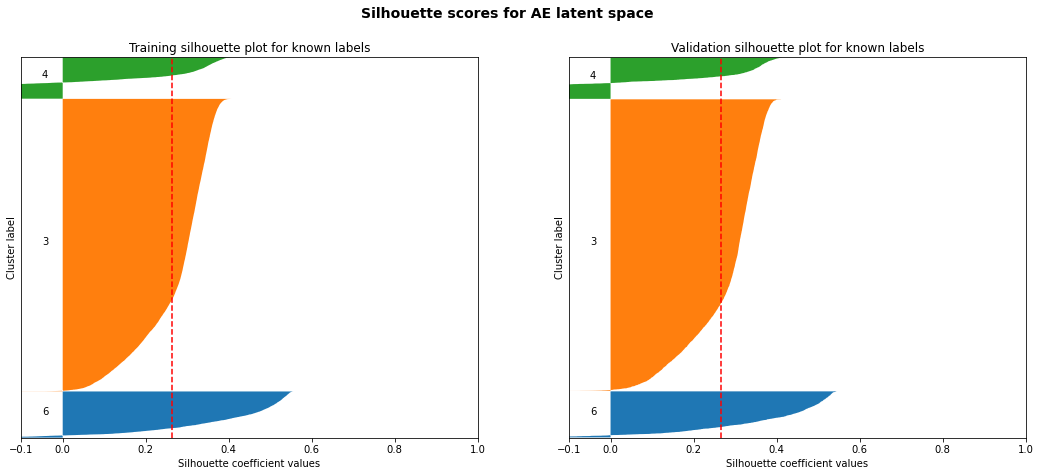

In [31]:
scRNA_silhouette(ae_history_train, ae_history_val, test_y , 4, 'AE')